In [ ]:
"""
F1 Safety Car Prediction ETL Pipeline

This module provides utilities for processing Formula 1 data through various stages:
1. Raw fastf1 data extraction
2. Data aggregation across sessions/races
3. Label encoding for track status
4. Time series sequence generation
5. Feature engineering enhancement
"""

import fastf1
import pandas as pd
import numpy as np
from typing import List, Dict, Any, Optional, Tuple, Union
from dataclasses import dataclass
from pathlib import Path
import pickle
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

@dataclass
class SessionConfig:
    """Configuration for a single F1 session"""
    year: int
    race: str  # e.g., 'Saudi Arabian Grand Prix'
    session_type: str  # 'R' for race, 'Q' for qualifying, etc.

@dataclass 
class DataConfig:
    """Configuration for data processing"""
    sessions: List[SessionConfig]
    drivers: Optional[List[str]] = None  # None = all drivers
    telemetry_frequency: Union[str, int] = 'original'
    include_weather: bool = True
    cache_dir: Optional[str] = None

class RawDataExtractor:
    """Handles extraction of raw fastf1 data"""
    
    def __init__(self, cache_dir: Optional[str] = None):
        self.cache_dir = Path(cache_dir) if cache_dir else None
        if self.cache_dir:
            self.cache_dir.mkdir(exist_ok=True)
    
    def extract_session(self, config: SessionConfig) -> Dict[str, Any]:
        """Extract all data for a single session"""
        print(f"Loading session: {config.year} {config.race} {config.session_type}")
        
        # Check cache first
        cache_key = f"{config.year}_{config.race}_{config.session_type}".replace(' ', '_')
        cache_file = self.cache_dir / f"{cache_key}.pkl" if self.cache_dir else None
        
        if cache_file and cache_file.exists():
            print(f"Loading from cache: {cache_file}")
            with open(cache_file, 'rb') as f:
                return pickle.load(f)
        
        # Load session
        session = fastf1.get_session(config.year, config.race, config.session_type)
        session.load()
        
        # Create mapping from driver numbers to abbreviations
        driver_mapping = {}
        for driver_number in session.drivers:
            driver_info = session.get_driver(driver_number)
            driver_mapping[driver_number] = driver_info['Abbreviation']
        
        # Extract all relevant data
        session_data = {
            'session_info': {
                'year': config.year,
                'race': config.race,
                'session_type': config.session_type,
                'event_name': session.event.EventName,
                'event_date': session.event.EventDate,
                'session_start': session.session_start_time,
                't0_date': session.t0_date  # Add this for time alignment
            },
            'laps': session.laps,
            'weather': session.weather_data,
            'track_status': session.track_status,
            'car_data': {},
            'pos_data': {},
            'drivers': list(session.drivers),  # Driver numbers as strings
            'driver_mapping': driver_mapping  # Add mapping for later use
        }
        
        # Extract telemetry for each driver using abbreviations
        for driver_number in session_data['drivers']:
            try:
                session_data['car_data'][driver_number] = session.car_data[driver_number]
                session_data['pos_data'][driver_number] = session.pos_data[driver_number]
            except Exception as e:
                abbreviation = driver_mapping.get(driver_number, driver_number)
                print(f"Warning: Could not extract telemetry for driver ({abbreviation}, {driver_number}): {e}")
        
        # Cache the result
        if cache_file:
            with open(cache_file, 'wb') as f:
                pickle.dump(session_data, f)
        
        return session_data

class DataAggregator:
    """Aggregates raw data across multiple sessions"""
    
    def __init__(self):
        self.aggregated_data = defaultdict(list)
    
    def aggregate_lap_data(self, sessions_data: List[Dict[str, Any]]) -> pd.DataFrame:
        """Aggregate lap data across sessions with session identifiers"""
        all_laps = []
        
        for session_data in sessions_data:
            laps = session_data['laps'].copy()
            
            # Add session identifiers
            laps['SessionYear'] = session_data['session_info']['year']
            laps['SessionRace'] = session_data['session_info']['race']
            laps['SessionType'] = session_data['session_info']['session_type']
            laps['SessionId'] = f"{session_data['session_info']['year']}_{session_data['session_info']['race']}_{session_data['session_info']['session_type']}"
            
            all_laps.append(laps)
        
        return pd.concat(all_laps, ignore_index=True)
    
    def aggregate_telemetry_data(self, sessions_data: List[Dict[str, Any]], 
                            drivers: Optional[List[str]] = None) -> pd.DataFrame:
        """Aggregate telemetry data across sessions with track status alignment"""
        all_telemetry = []
        
        for session_data in sessions_data:
            session_telemetry = self._merge_session_telemetry(session_data, drivers)
            
            # Add session identifiers
            session_telemetry['SessionYear'] = session_data['session_info']['year']
            session_telemetry['SessionRace'] = session_data['session_info']['race']
            session_telemetry['SessionType'] = session_data['session_info']['session_type']
            session_telemetry['SessionId'] = f"{session_data['session_info']['year']}_{session_data['session_info']['race']}_{session_data['session_info']['session_type']}"
            
            # Align track status with telemetry timestamps
            track_status = session_data.get('track_status', pd.DataFrame())
            t0_date = session_data['session_info']['t0_date']  # Get t0_date from session info
            session_telemetry = self._align_track_status(session_telemetry, track_status, t0_date)
            
            all_telemetry.append(session_telemetry)
        
        return pd.concat(all_telemetry, ignore_index=True)

    def _align_track_status(self, telemetry: pd.DataFrame, track_status: pd.DataFrame, t0_date) -> pd.DataFrame:
        """Align track status with telemetry timestamps using forward fill"""
        if track_status is None or track_status.empty or telemetry.empty:
            # If no track status data or no telemetry data, assume track clear
            if not telemetry.empty:
                telemetry['TrackStatus'] = '1'
                telemetry['TrackStatusMessage'] = 'AllClear'
            return telemetry
        
        # Check if we have the required columns in telemetry
        if 'Date' not in telemetry.columns:
            print("Warning: No Date column in telemetry data, skipping track status alignment")
            telemetry['TrackStatus'] = '1'
            telemetry['TrackStatusMessage'] = 'AllClear'
            return telemetry
        
        # Track status data structure from FastF1
        track_status = track_status.copy()
        
        # Check if track status has the expected structure
        if 'Time' not in track_status.columns or 'Status' not in track_status.columns:
            print("Warning: Track status data missing required columns, using default")
            telemetry['TrackStatus'] = '1'
            telemetry['TrackStatusMessage'] = 'AllClear'
            return telemetry
        
        try:
            # Convert track status SessionTime to absolute Date using t0_date
            track_status_with_date = track_status.copy()
            track_status_with_date['Date'] = t0_date + track_status_with_date['Time']
            
            # Get available columns from track status
            status_cols = ['Date', 'Status']
            if 'Message' in track_status_with_date.columns:
                status_cols.append('Message')
            
            # Forward fill track status for all telemetry timestamps
            telemetry_with_status = pd.merge_asof(
                telemetry.sort_values('Date'),
                track_status_with_date[status_cols].sort_values('Date'),
                on='Date',
                direction='backward'
            ).fillna({'Status': '1'})
            
            if 'Message' not in telemetry_with_status.columns:
                telemetry_with_status['Message'] = 'AllClear'
            else:
                telemetry_with_status['Message'] = telemetry_with_status['Message'].fillna('AllClear')
            
            telemetry_with_status = telemetry_with_status.rename(columns={
                'Status': 'TrackStatus',
                'Message': 'TrackStatusMessage'
            })
            
            return telemetry_with_status
            
        except Exception as e:
            print(f"Warning: Failed to align track status: {e}")
            telemetry['TrackStatus'] = '1'
            telemetry['TrackStatusMessage'] = 'AllClear'
            return telemetry
    
    def _merge_session_telemetry(self, session_data: Dict[str, Any], 
                               drivers: Optional[List[str]] = None) -> pd.DataFrame:
        """Merge car and position data for a single session"""
        session_drivers = drivers if drivers else session_data['drivers']
        session_telemetry = []
        
        for driver_number in session_drivers:
            if driver_number not in session_data['car_data']:
                continue
                
            try:
                # Get car and position data
                car_data = session_data['car_data'][driver_number]
                pos_data = session_data['pos_data'][driver_number]
                
                # Merge using fastf1's native method
                merged = car_data.merge_channels(pos_data, frequency='original')
                
                # Add computed channels
                merged = merged.add_distance().add_differential_distance()
                
                # Add driver identifier (use driver number)
                merged['Driver'] = driver_number
                
                session_telemetry.append(merged)
                
            except Exception as e:
                print(f"Warning: Could not merge telemetry for driver {driver_number}: {e}")
        
        if session_telemetry:
            result = pd.concat(session_telemetry, ignore_index=True)
            # Ensure we have the required columns
            if 'Date' not in result.columns and 'Time' in result.columns:
                result = result.rename(columns={'Time': 'Date'})
            elif 'Date' not in result.columns and hasattr(result, 'index') and hasattr(result.index, 'name'):
                # If Date is the index, reset it
                result = result.reset_index()
                if 'index' in result.columns:
                    result = result.rename(columns={'index': 'Date'})
            return result
        else:
            return pd.DataFrame()

class DriverLabelEncoder:
    """Encodes driver identifiers for consistency"""
    
    def __init__(self):
        self.label_encoder = LabelEncoder()
        self.is_fitted = False
        self.driver_to_number = {}  # Maps abbreviations to driver numbers
        self.number_to_driver = {}  # Maps driver numbers to abbreviations
    
    def fit_session(self, session) -> 'DriverLabelEncoder':
        """Fit the encoder using session driver data"""
        driver_numbers = session.drivers
        
        for driver_number in driver_numbers:
            driver_info = session.get_driver(driver_number)
            abbreviation = driver_info['Abbreviation']
            
            self.driver_to_number[abbreviation] = driver_number
            self.number_to_driver[driver_number] = abbreviation
        
        # Fit encoder on abbreviations for consistent encoding
        abbreviations = list(self.driver_to_number.keys())
        self.label_encoder.fit(abbreviations)
        self.is_fitted = True
        return self
    
    def transform_driver_to_number(self, drivers):
        """Transform driver abbreviations to driver numbers"""
        if not self.is_fitted:
            raise ValueError("Encoder not fitted")
        return [self.driver_to_number[driver] for driver in drivers]
    
    def transform_number_to_driver(self, numbers):
        """Transform driver numbers to abbreviations"""
        if not self.is_fitted:
            raise ValueError("Encoder not fitted")
        return [self.number_to_driver[number] for number in numbers]

class TrackStatusLabelEncoder:
    """Encodes track status labels for safety car prediction"""
    
    def __init__(self):
        self.label_encoder = LabelEncoder()
        self.is_fitted = False
        self.track_status_mapping = {
            '1': 'green',      # Track clear
            '2': 'yellow',     # Yellow flag
            '4': 'safety_car', # Safety car deployed
            '5': 'red',        # Red flag
            '6': 'vsc',        # Virtual safety car
            '7': 'vsc_ending'  # VSC ending
        }
    
    def fit(self, track_status_data: pd.Series) -> 'TrackStatusLabelEncoder':
        """Fit the label encoder on track status data"""
        # Map numeric codes to readable labels
        mapped_labels = track_status_data.map(self.track_status_mapping).fillna('unknown')
        
        self.label_encoder.fit(mapped_labels)
        self.is_fitted = True
        return self
    
    def transform(self, track_status_data: pd.Series) -> np.ndarray:
        """Transform track status data to encoded labels"""
        if not self.is_fitted:
            raise ValueError("LabelEncoder must be fitted before transform")
        
        mapped_labels = track_status_data.map(self.track_status_mapping).fillna('unknown')
        return self.label_encoder.transform(mapped_labels)
    
    def fit_transform(self, track_status_data: pd.Series) -> np.ndarray:
        """Fit and transform in one step"""
        return self.fit(track_status_data).transform(track_status_data)
    
    def inverse_transform(self, encoded_labels: np.ndarray) -> np.ndarray:
        """Convert encoded labels back to readable format"""
        return self.label_encoder.inverse_transform(encoded_labels)
    
    def get_classes(self) -> np.ndarray:
        """Get the class labels"""
        return self.label_encoder.classes_

class TimeSeriesGenerator:
    """Generates sliding window time series sequences from telemetry data"""
    
    def __init__(self, window_size: int, step_size: int = 1, 
                 features: Optional[List[str]] = None,
                 prediction_horizon: int = 1,
                 padding_strategy: str = 'none',  # 'none', 'zero', 'repeat_last'
                 truncation_strategy: str = 'none'):  # 'none', 'trim_start', 'trim_end'
        self.window_size = window_size
        self.step_size = step_size
        self.prediction_horizon = prediction_horizon
        self.padding_strategy = padding_strategy
        self.truncation_strategy = truncation_strategy
        self.features = features or ['Speed', 'RPM', 'nGear', 'Throttle', 'Brake', 
                                   'X', 'Y', 'Distance', 'DifferentialDistance']
    
    def generate_sequences(self, telemetry_data: pd.DataFrame, 
                         group_by: List[str] = None) -> Tuple[np.ndarray, np.ndarray, List[Dict]]:
        """
        Generate sliding window sequences from telemetry data
        
        Returns:
            X: sequences of shape (n_sequences, window_size, n_features)
            y: labels of shape (n_sequences,) - track status at prediction horizon
            metadata: list of dicts with sequence metadata
        """
        if group_by is None:
            group_by = ['SessionId', 'Driver']
        
        sequences = []
        labels = []
        metadata = []
        
        # Group telemetry by session and driver
        for group_keys, group_data in telemetry_data.groupby(group_by):
            group_sequences, group_labels, group_metadata = self._generate_group_sequences(
                group_data, group_keys, group_by
            )
            sequences.extend(group_sequences)
            labels.extend(group_labels)
            metadata.extend(group_metadata)
        
        # Apply padding/truncation if specified
        if sequences:
            sequences = self._apply_length_adjustments(sequences)
        
        return np.array(sequences), np.array(labels), metadata
    
    def _generate_group_sequences(self, group_data: pd.DataFrame, 
                                group_keys: Tuple, group_by: List[str]) -> Tuple[List, List, List]:
        """Generate sequences for a single group (e.g., driver in session)"""
        # Sort by time to ensure proper sequence order
        group_data = group_data.sort_values('Date').reset_index(drop=True)
        
        sequences = []
        labels = []
        metadata = []
        
        # Extract feature data
        available_features = [f for f in self.features if f in group_data.columns]
        if len(available_features) != len(self.features):
            missing = set(self.features) - set(available_features)
            print(f"Warning: Missing features {missing}, using {available_features}")
        
        feature_data = group_data[available_features].values
        
        # Generate sliding windows
        max_start_idx = len(feature_data) - self.window_size - self.prediction_horizon + 1
        for i in range(0, max_start_idx, self.step_size):
            # Extract sequence
            sequence = feature_data[i:i + self.window_size]
            
            # Label is the track status at prediction horizon after the sequence
            label_idx = i + self.window_size + self.prediction_horizon - 1
            if label_idx < len(group_data):
                label = group_data.iloc[label_idx]['TrackStatus']
            else:
                continue  # Skip if we don't have future data
            
            # Metadata for this sequence
            seq_metadata = {
                'start_time': group_data.iloc[i]['Date'],
                'end_time': group_data.iloc[i + self.window_size - 1]['Date'],
                'prediction_time': group_data.iloc[label_idx]['Date'],
                'sequence_length': self.window_size,
                'prediction_horizon': self.prediction_horizon,
                'features_used': available_features
            }
            
            # Add group identifiers to metadata
            for j, key in enumerate(group_by):
                seq_metadata[key] = group_keys[j] if isinstance(group_keys, tuple) else group_keys
            
            sequences.append(sequence)
            labels.append(label)
            metadata.append(seq_metadata)
        
        return sequences, labels, metadata
    
    def _apply_length_adjustments(self, sequences: List[np.ndarray]) -> List[np.ndarray]:
        """Apply padding or truncation strategies to handle variable length sequences"""
        if not sequences:
            return sequences
        
        lengths = [len(seq) for seq in sequences]
        target_length = self.window_size
        
        adjusted_sequences = []
        for seq in sequences:
            if len(seq) == target_length:
                adjusted_sequences.append(seq)
            elif len(seq) < target_length:
                # Sequence is too short - apply padding
                adjusted_sequences.append(self._pad_sequence(seq, target_length))
            else:
                # Sequence is too long - apply truncation
                adjusted_sequences.append(self._truncate_sequence(seq, target_length))
        
        return adjusted_sequences
    
    def _pad_sequence(self, sequence: np.ndarray, target_length: int) -> np.ndarray:
        """Pad sequence to target length"""
        if self.padding_strategy == 'none':
            return sequence
        elif self.padding_strategy == 'zero':
            padding = np.zeros((target_length - len(sequence), sequence.shape[1]))
            return np.vstack([sequence, padding])
        elif self.padding_strategy == 'repeat_last':
            if len(sequence) > 0:
                last_row = np.tile(sequence[-1:], (target_length - len(sequence), 1))
                return np.vstack([sequence, last_row])
            else:
                return np.zeros((target_length, sequence.shape[1] if len(sequence.shape) > 1 else 1))
        else:
            raise ValueError(f"Unknown padding strategy: {self.padding_strategy}")
    
    def _truncate_sequence(self, sequence: np.ndarray, target_length: int) -> np.ndarray:
        """Truncate sequence to target length"""
        if self.truncation_strategy == 'none':
            return sequence
        elif self.truncation_strategy == 'trim_start':
            return sequence[-target_length:]
        elif self.truncation_strategy == 'trim_end':
            return sequence[:target_length]
        else:
            raise ValueError(f"Unknown truncation strategy: {self.truncation_strategy}")

class FeatureEngineer:
    """Applies feature engineering to time series data"""
    
    def __init__(self):
        self.transformers = {}
        self.is_fitted = {}
    
    def apply_basic_features(self, X: np.ndarray) -> np.ndarray:
        """Apply basic statistical features (mean, std, min, max per sequence)"""
        n_sequences, seq_length, n_features = X.shape
        
        # Calculate statistical features for each sequence
        features = []
        for i in range(n_sequences):
            seq_features = []
            for j in range(n_features):
                feature_series = X[i, :, j]
                seq_features.extend([
                    np.mean(feature_series),
                    np.std(feature_series),
                    np.min(feature_series),
                    np.max(feature_series),
                    np.median(feature_series)
                ])
            features.append(seq_features)
        
        return np.array(features)
    
    def apply_catch22(self, X: np.ndarray, fit: bool = True) -> np.ndarray:
        """Apply Catch22 feature extraction (placeholder for future implementation)"""
        # Note: This is a placeholder - actual Catch22 implementation will be added later
        # For now, just return basic statistical features
        print("Warning: Using basic features instead of Catch22 (not yet implemented)")
        return self.apply_basic_features(X)
    
    def normalize_sequences(self, X: np.ndarray, method: str = 'standard', 
                           fit: bool = True) -> np.ndarray:
        """Normalize time series sequences"""
        transformer_key = f"{method}_normalizer"
        
        if method == 'standard':
            # Z-score normalization per feature across all sequences
            if fit or transformer_key not in self.transformers:
                # Calculate mean and std across all sequences and time steps
                means = np.mean(X, axis=(0, 1), keepdims=True)
                stds = np.std(X, axis=(0, 1), keepdims=True)
                stds = np.where(stds == 0, 1, stds)  # Avoid division by zero
                
                self.transformers[transformer_key] = {'means': means, 'stds': stds}
                self.is_fitted[transformer_key] = True
            
            params = self.transformers[transformer_key]
            return (X - params['means']) / params['stds']
            
        elif method == 'minmax':
            # Min-max normalization per feature
            if fit or transformer_key not in self.transformers:
                mins = np.min(X, axis=(0, 1), keepdims=True)
                maxs = np.max(X, axis=(0, 1), keepdims=True)
                ranges = maxs - mins
                ranges = np.where(ranges == 0, 1, ranges)  # Avoid division by zero
                
                self.transformers[transformer_key] = {'mins': mins, 'ranges': ranges}
                self.is_fitted[transformer_key] = True
            
            params = self.transformers[transformer_key]
            return (X - params['mins']) / params['ranges']
            
        elif method == 'per_sequence':
            # Normalize each sequence independently
            normalized = np.zeros_like(X)
            for i in range(X.shape[0]):
                seq = X[i]
                seq_mean = np.mean(seq, axis=0, keepdims=True)
                seq_std = np.std(seq, axis=0, keepdims=True)
                seq_std = np.where(seq_std == 0, 1, seq_std)
                normalized[i] = (seq - seq_mean) / seq_std
            return normalized
            
        else:
            raise ValueError(f"Unknown normalization method: {method}")
    
    def handle_missing_values(self, X: np.ndarray, strategy: str = 'forward_fill') -> np.ndarray:
        """Handle missing values in time series sequences"""
        X_filled = X.copy()
        
        if strategy == 'forward_fill':
            # Forward fill missing values within each sequence
            for i in range(X.shape[0]):  # For each sequence
                for j in range(X.shape[2]):  # For each feature
                    series = X_filled[i, :, j]
                    mask = np.isnan(series)
                    if mask.any():
                        # Forward fill
                        valid_indices = np.where(~mask)[0]
                        if len(valid_indices) > 0:
                            # Use numpy interp for forward fill approximation
                            filled_values = np.full_like(series, np.nan)
                            filled_values[valid_indices] = series[valid_indices]
                            # Forward fill manually
                            last_valid = np.nan
                            for k in range(len(filled_values)):
                                if not np.isnan(filled_values[k]):
                                    last_valid = filled_values[k]
                                elif not np.isnan(last_valid):
                                    filled_values[k] = last_valid
                            series[:] = filled_values
                        X_filled[i, :, j] = series
                        
        elif strategy == 'mean_fill':
            # Fill with feature mean across all sequences
            for j in range(X.shape[2]):
                feature_data = X[:, :, j]
                feature_mean = np.nanmean(feature_data)
                X_filled[:, :, j] = np.where(np.isnan(feature_data), feature_mean, feature_data)
                
        elif strategy == 'zero_fill':
            # Fill with zeros
            X_filled = np.where(np.isnan(X_filled), 0, X_filled)
            
        else:
            raise ValueError(f"Unknown missing value strategy: {strategy}")
        
        return X_filled

# Example usage pipeline
def create_safety_car_dataset(config: DataConfig, 
                             window_size: int = 100,
                             prediction_horizon: int = 10,
                             padding_strategy: str = 'none',
                             truncation_strategy: str = 'none') -> Dict[str, Any]:
    """Complete ETL pipeline for safety car prediction dataset"""
    
    # Step 1: Extract raw data
    extractor = RawDataExtractor(config.cache_dir)
    sessions_data = [extractor.extract_session(session_config) 
                    for session_config in config.sessions]
    
    # Step 2: Aggregate data with track status alignment
    aggregator = DataAggregator()
    telemetry_data = aggregator.aggregate_telemetry_data(sessions_data, config.drivers)
    
    # Step 3: Encode labels
    label_encoder = TrackStatusLabelEncoder()
    if 'TrackStatus' in telemetry_data.columns:
        encoded_labels = label_encoder.fit_transform(telemetry_data['TrackStatus'])
        telemetry_data['TrackStatusEncoded'] = encoded_labels
    else:
        print("Warning: No track status data found")
        return None
    
    # Step 4: Generate time series sequences with prediction horizon
    ts_generator = TimeSeriesGenerator(
        window_size=window_size, 
        step_size=window_size // 2,  # 50% overlap
        prediction_horizon=prediction_horizon,
        padding_strategy=padding_strategy,
        truncation_strategy=truncation_strategy
    )
    X, y, metadata = ts_generator.generate_sequences(telemetry_data)
    
    # Step 5: Encode the prediction labels
    y_encoded = label_encoder.transform(pd.Series(y))
    
    # Step 6: Apply basic feature engineering
    engineer = FeatureEngineer()
    
    # Handle missing values first
    X_clean = engineer.handle_missing_values(X)
    
    # Normalize sequences
    X_normalized = engineer.normalize_sequences(X_clean, method='standard')
    
    # Calculate class distribution for analysis
    unique, counts = np.unique(y_encoded, return_counts=True)
    class_distribution = dict(zip(unique, counts))
    
    return {
        'X': X_normalized,
        'y': y_encoded,
        'y_raw': y,
        'metadata': metadata,
        'label_encoder': label_encoder,
        'raw_telemetry': telemetry_data,
        'class_distribution': class_distribution,
        'feature_engineer': engineer,
        'config': {
            'window_size': window_size,
            'prediction_horizon': prediction_horizon,
            'padding_strategy': padding_strategy,
            'truncation_strategy': truncation_strategy,
            'n_sequences': len(X_normalized),
            'n_features': X_normalized.shape[2] if len(X_normalized) > 0 else 0
        }
    }

In [2]:
"""
F1 Safety Car Prediction ETL Pipeline - Fixed Version

Key fixes:
1. Proper handling of mixed data types from FastF1
2. Feature validation and type checking
3. Preprocessing order following aeon principles
4. Avoid redundant preprocessing steps
"""

import fastf1
import pandas as pd
import numpy as np
from typing import List, Dict, Any, Optional, Tuple, Union
from dataclasses import dataclass
from pathlib import Path
import pickle
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import warnings

@dataclass
class SessionConfig:
    """Configuration for a single F1 session"""
    year: int
    race: str
    session_type: str

@dataclass 
class DataConfig:
    """Configuration for data processing"""
    sessions: List[SessionConfig]
    drivers: Optional[List[str]] = None
    telemetry_frequency: Union[str, int] = 'original'
    include_weather: bool = True
    cache_dir: Optional[str] = None

class RawDataExtractor:
    """Handles extraction of raw fastf1 data"""
    
    def __init__(self, cache_dir: Optional[str] = None):
        self.cache_dir = Path(cache_dir) if cache_dir else None
        if self.cache_dir:
            self.cache_dir.mkdir(exist_ok=True)
    
    def extract_session(self, config: SessionConfig) -> Dict[str, Any]:
        """Extract all data for a single session"""
        print(f"Loading session: {config.year} {config.race} {config.session_type}")
        
        cache_key = f"{config.year}_{config.race}_{config.session_type}".replace(' ', '_')
        cache_file = self.cache_dir / f"{cache_key}.pkl" if self.cache_dir else None
        
        if cache_file and cache_file.exists():
            print(f"Loading from cache: {cache_file}")
            with open(cache_file, 'rb') as f:
                return pickle.load(f)
        
        session = fastf1.get_session(config.year, config.race, config.session_type)
        session.load()
        
        driver_mapping = {}
        for driver_number in session.drivers:
            driver_info = session.get_driver(driver_number)
            driver_mapping[driver_number] = driver_info['Abbreviation']
        
        session_data = {
            'session_info': {
                'year': config.year,
                'race': config.race,
                'session_type': config.session_type,
                'event_name': session.event.EventName,
                'event_date': session.event.EventDate,
                'session_start': session.session_start_time,
                't0_date': session.t0_date
            },
            'laps': session.laps,
            'weather': session.weather_data,
            'track_status': session.track_status,
            'car_data': {},
            'pos_data': {},
            'drivers': list(session.drivers),
            'driver_mapping': driver_mapping
        }
        
        for driver_number in session_data['drivers']:
            try:
                session_data['car_data'][driver_number] = session.car_data[driver_number]
                session_data['pos_data'][driver_number] = session.pos_data[driver_number]
            except Exception as e:
                abbreviation = driver_mapping.get(driver_number, driver_number)
                print(f"Warning: Could not extract telemetry for driver ({abbreviation}, {driver_number}): {e}")
        
        if cache_file:
            with open(cache_file, 'wb') as f:
                pickle.dump(session_data, f)
        
        return session_data

class DataAggregator:
    """Aggregates raw data across multiple sessions"""
    
    def __init__(self):
        self.aggregated_data = defaultdict(list)
    
    def aggregate_telemetry_data(self, sessions_data: List[Dict[str, Any]], 
                            drivers: Optional[List[str]] = None) -> pd.DataFrame:
        """Aggregate telemetry data across sessions with track status alignment"""
        all_telemetry = []
        
        for session_data in sessions_data:
            session_telemetry = self._merge_session_telemetry(session_data, drivers)
            
            session_telemetry['SessionYear'] = session_data['session_info']['year']
            session_telemetry['SessionRace'] = session_data['session_info']['race']
            session_telemetry['SessionType'] = session_data['session_info']['session_type']
            session_telemetry['SessionId'] = f"{session_data['session_info']['year']}_{session_data['session_info']['race']}_{session_data['session_info']['session_type']}"
            
            track_status = session_data.get('track_status', pd.DataFrame())
            t0_date = session_data['session_info']['t0_date']
            session_telemetry = self._align_track_status(session_telemetry, track_status, t0_date)
            
            all_telemetry.append(session_telemetry)
        
        return pd.concat(all_telemetry, ignore_index=True)

    def _align_track_status(self, telemetry: pd.DataFrame, track_status: pd.DataFrame, t0_date) -> pd.DataFrame:
        """Align track status with telemetry timestamps using forward fill"""
        if track_status is None or track_status.empty or telemetry.empty:
            if not telemetry.empty:
                telemetry['TrackStatus'] = '1'
                telemetry['TrackStatusMessage'] = 'AllClear'
            return telemetry
        
        if 'Date' not in telemetry.columns:
            print("Warning: No Date column in telemetry data, skipping track status alignment")
            telemetry['TrackStatus'] = '1'
            telemetry['TrackStatusMessage'] = 'AllClear'
            return telemetry
        
        if 'Time' not in track_status.columns or 'Status' not in track_status.columns:
            print("Warning: Track status data missing required columns, using default")
            telemetry['TrackStatus'] = '1'
            telemetry['TrackStatusMessage'] = 'AllClear'
            return telemetry
        
        try:
            track_status_with_date = track_status.copy()
            track_status_with_date['Date'] = t0_date + track_status_with_date['Time']
            
            status_cols = ['Date', 'Status']
            if 'Message' in track_status_with_date.columns:
                status_cols.append('Message')
            
            telemetry_with_status = pd.merge_asof(
                telemetry.sort_values('Date'),
                track_status_with_date[status_cols].sort_values('Date'),
                on='Date',
                direction='backward'
            ).fillna({'Status': '1'})
            
            if 'Message' not in telemetry_with_status.columns:
                telemetry_with_status['Message'] = 'AllClear'
            else:
                telemetry_with_status['Message'] = telemetry_with_status['Message'].fillna('AllClear')
            
            telemetry_with_status = telemetry_with_status.rename(columns={
                'Status': 'TrackStatus',
                'Message': 'TrackStatusMessage'
            })
            
            return telemetry_with_status
            
        except Exception as e:
            print(f"Warning: Failed to align track status: {e}")
            telemetry['TrackStatus'] = '1'
            telemetry['TrackStatusMessage'] = 'AllClear'
            return telemetry
    
    def _merge_session_telemetry(self, session_data: Dict[str, Any], 
                               drivers: Optional[List[str]] = None) -> pd.DataFrame:
        """Merge car and position data for a single session"""
        session_drivers = drivers if drivers else session_data['drivers']
        session_telemetry = []
        
        for driver_number in session_drivers:
            if driver_number not in session_data['car_data']:
                continue
                
            try:
                car_data = session_data['car_data'][driver_number]
                pos_data = session_data['pos_data'][driver_number]
                
                merged = car_data.merge_channels(pos_data, frequency='original')
                merged = merged.add_distance().add_differential_distance()
                merged['Driver'] = driver_number
                
                session_telemetry.append(merged)
                
            except Exception as e:
                print(f"Warning: Could not merge telemetry for driver {driver_number}: {e}")
        
        if session_telemetry:
            result = pd.concat(session_telemetry, ignore_index=True)
            if 'Date' not in result.columns and 'Time' in result.columns:
                result = result.rename(columns={'Time': 'Date'})
            elif 'Date' not in result.columns and hasattr(result, 'index') and hasattr(result.index, 'name'):
                result = result.reset_index()
                if 'index' in result.columns:
                    result = result.rename(columns={'index': 'Date'})
            return result
        else:
            return pd.DataFrame()

class TrackStatusLabelEncoder:
    """Encodes track status labels for safety car prediction"""
    
    def __init__(self):
        self.label_encoder = LabelEncoder()
        self.is_fitted = False
        self.track_status_mapping = {
            '1': 'green',
            '2': 'yellow',
            '4': 'safety_car',
            '5': 'red',
            '6': 'vsc',
            '7': 'vsc_ending'
        }
    
    def fit(self, track_status_data: pd.Series) -> 'TrackStatusLabelEncoder':
        mapped_labels = track_status_data.map(self.track_status_mapping).fillna('unknown')
        self.label_encoder.fit(mapped_labels)
        self.is_fitted = True
        return self
    
    def transform(self, track_status_data: pd.Series) -> np.ndarray:
        if not self.is_fitted:
            raise ValueError("LabelEncoder must be fitted before transform")
        mapped_labels = track_status_data.map(self.track_status_mapping).fillna('unknown')
        return self.label_encoder.transform(mapped_labels)
    
    def fit_transform(self, track_status_data: pd.Series) -> np.ndarray:
        return self.fit(track_status_data).transform(track_status_data)
    
    def inverse_transform(self, encoded_labels: np.ndarray) -> np.ndarray:
        return self.label_encoder.inverse_transform(encoded_labels)
    
    def get_classes(self) -> np.ndarray:
        return self.label_encoder.classes_

class FeatureEngineer:
    """Applies feature engineering to time series data"""
    
    def __init__(self):
        self.normalization_params = {}
        self.is_fitted = False
    
    def handle_missing_values(self, X: np.ndarray, strategy: str = 'forward_fill') -> np.ndarray:
        """Handle missing values in numeric time series data"""
        if not np.isnan(X).any():
            print("No missing values detected, skipping imputation")
            return X
        
        print(f"Handling missing values with strategy: {strategy}")
        X_filled = X.copy()
        
        if strategy == 'forward_fill':
            for i in range(X.shape[0]):
                for j in range(X.shape[2]):
                    series = X_filled[i, :, j]
                    mask = np.isnan(series)
                    if mask.any():
                        last_valid = None
                        for k in range(len(series)):
                            if not np.isnan(series[k]):
                                last_valid = series[k]
                            elif last_valid is not None:
                                series[k] = last_valid
                        
                        if np.isnan(series[0]):
                            valid_indices = np.where(~np.isnan(series))[0]
                            if len(valid_indices) > 0:
                                fill_value = series[valid_indices[0]]
                                for k in range(valid_indices[0]):
                                    series[k] = fill_value
                        X_filled[i, :, j] = series
        elif strategy == 'mean_fill':
            for j in range(X.shape[2]):
                feature_data = X[:, :, j]
                feature_mean = np.nanmean(feature_data)
                X_filled[:, :, j] = np.where(np.isnan(feature_data), feature_mean, feature_data)
        elif strategy == 'zero_fill':
            X_filled = np.where(np.isnan(X_filled), 0, X_filled)
            
        return X_filled
    
    def normalize_sequences(self, X: np.ndarray, method: str = 'standard', 
                           fit: bool = True) -> np.ndarray:
        """Normalize time series sequences"""
        if method == 'standard':
            if fit or not self.is_fitted:
                means = np.mean(X, axis=(0, 1), keepdims=True)
                stds = np.std(X, axis=(0, 1), keepdims=True)
                stds = np.where(stds == 0, 1, stds)
                self.normalization_params = {'means': means, 'stds': stds}
                self.is_fitted = True
            
            params = self.normalization_params
            return (X - params['means']) / params['stds']
            
        elif method == 'minmax':
            if fit or not self.is_fitted:
                mins = np.min(X, axis=(0, 1), keepdims=True)
                maxs = np.max(X, axis=(0, 1), keepdims=True)
                ranges = maxs - mins
                ranges = np.where(ranges == 0, 1, ranges)
                self.normalization_params = {'mins': mins, 'ranges': ranges}
                self.is_fitted = True
            
            params = self.normalization_params
            return (X - params['mins']) / params['ranges']
            
        elif method == 'per_sequence':
            normalized = np.zeros_like(X)
            for i in range(X.shape[0]):
                seq = X[i]
                seq_mean = np.mean(seq, axis=0, keepdims=True)
                seq_std = np.std(seq, axis=0, keepdims=True)
                seq_std = np.where(seq_std == 0, 1, seq_std)
                normalized[i] = (seq - seq_mean) / seq_std
            return normalized
            
        else:
            raise ValueError(f"Unknown normalization method: {method}")

class TimeSeriesGenerator:
    """Generates sliding window time series sequences from telemetry data"""
    
    def __init__(self, window_size: int, step_size: int = 1, 
                 features: Optional[List[str]] = None,
                 prediction_horizon: int = 1,
                 handle_non_numeric: str = 'encode'):  # 'encode' or 'drop'
        self.window_size = window_size
        self.step_size = step_size
        self.prediction_horizon = prediction_horizon
        self.handle_non_numeric = handle_non_numeric
        self.features = features or [
            'Speed', 'RPM', 'nGear', 'Throttle', 'Brake', 
            'X', 'Y', 'Distance', 'DifferentialDistance'
        ]
    
    def _process_features(self, group_data: pd.DataFrame) -> Tuple[np.ndarray, List[str]]:
        """
        Process features to handle non-numeric data types
        Returns numpy array with proper dtype and list of processed feature names
        """
        available_features = [f for f in self.features if f in group_data.columns]
        if not available_features:
            raise ValueError(f"No requested features found in data. Available: {list(group_data.columns)}")
        
        feature_data = group_data[available_features].copy()
        processed_features = []
        
        for feature in available_features:
            col = feature_data[feature]
            
            if pd.api.types.is_numeric_dtype(col):
                # Already numeric, keep as-is
                processed_features.append(feature)
            elif pd.api.types.is_bool_dtype(col) or col.dtype == 'bool':
                # Boolean - encode as 0/1
                if self.handle_non_numeric == 'encode':
                    feature_data[feature] = col.astype(int)
                    processed_features.append(feature)
                    print(f"Encoded boolean feature '{feature}' as 0/1")
                elif self.handle_non_numeric == 'drop':
                    print(f"Dropping boolean feature '{feature}'")
                    feature_data = feature_data.drop(columns=[feature])
            elif col.dtype == 'object':
                # Check if it's actually numeric stored as object
                try:
                    converted = pd.to_numeric(col, errors='coerce')
                    if not converted.isna().all():
                        feature_data[feature] = converted
                        processed_features.append(feature)
                        print(f"Converted object feature '{feature}' to numeric")
                    else:
                        # Non-numeric object
                        if self.handle_non_numeric == 'encode':
                            # Simple label encoding for categorical
                            unique_vals = col.unique()
                            mapping = {val: i for i, val in enumerate(unique_vals)}
                            feature_data[feature] = col.map(mapping)
                            processed_features.append(feature)
                            print(f"Label encoded categorical feature '{feature}': {mapping}")
                        elif self.handle_non_numeric == 'drop':
                            print(f"Dropping non-numeric feature '{feature}'")
                            feature_data = feature_data.drop(columns=[feature])
                except Exception as e:
                    print(f"Could not process feature '{feature}': {e}")
                    if self.handle_non_numeric == 'drop':
                        feature_data = feature_data.drop(columns=[feature])
            else:
                # Other data types
                if self.handle_non_numeric == 'drop':
                    print(f"Dropping unsupported feature '{feature}' (dtype: {col.dtype})")
                    feature_data = feature_data.drop(columns=[feature])
                else:
                    print(f"Warning: Attempting to convert '{feature}' (dtype: {col.dtype}) to numeric")
                    try:
                        feature_data[feature] = pd.to_numeric(col, errors='coerce')
                        processed_features.append(feature)
                    except:
                        feature_data = feature_data.drop(columns=[feature])
        
        if feature_data.empty:
            raise ValueError("No valid features remaining after processing")
        
        # Convert to numeric numpy array
        try:
            feature_array = feature_data[processed_features].astype(np.float64).values
        except Exception as e:
            print(f"Error converting to float64: {e}")
            print(f"Data types: {feature_data[processed_features].dtypes}")
            raise
        
        return feature_array, processed_features
    
    def generate_sequences(self, telemetry_data: pd.DataFrame, 
                         group_by: List[str] = None) -> Tuple[np.ndarray, np.ndarray, List[Dict]]:
        """Generate sliding window sequences with built-in preprocessing"""
        if group_by is None:
            group_by = ['SessionId', 'Driver']
        
        sequences = []
        labels = []
        metadata = []
        
        print(f"Processing {len(telemetry_data)} total telemetry rows")
        print(f"Grouping by: {group_by}")
        print(f"Available columns: {list(telemetry_data.columns)}")
        
        group_count = 0
        for group_keys, group_data in telemetry_data.groupby(group_by):
            group_count += 1
            print(f"\nProcessing group {group_count}: {group_keys}")
            print(f"  Group size: {len(group_data)} rows")
            print(f"  Required minimum rows: {self.window_size + self.prediction_horizon}")
            
            try:
                group_sequences, group_labels, group_metadata = self._generate_group_sequences(
                    group_data, group_keys, group_by
                )
                print(f"  Generated {len(group_sequences)} sequences")
                sequences.extend(group_sequences)
                labels.extend(group_labels)
                metadata.extend(group_metadata)
                
            except Exception as e:
                print(f"  Error processing group {group_keys}: {e}")
                import traceback
                traceback.print_exc()
                continue
        
        print(f"\nTotal sequences generated: {len(sequences)}")
        if not sequences:
            print("Debugging info:")
            print(f"  Total groups processed: {group_count}")
            print(f"  Window size: {self.window_size}")
            print(f"  Prediction horizon: {self.prediction_horizon}")
            print(f"  Required features: {self.features}")
            
            # Check if TrackStatus column exists
            if 'TrackStatus' not in telemetry_data.columns:
                print(f"  ERROR: TrackStatus column missing! Available: {list(telemetry_data.columns)}")
            else:
                print(f"  TrackStatus values: {telemetry_data['TrackStatus'].unique()}")
            
            raise ValueError("No sequences generated - see debug output above")
        
        return np.array(sequences), np.array(labels), metadata
    
    def _generate_group_sequences(self, group_data: pd.DataFrame, 
                                group_keys: Tuple, 
                                group_by: List[str]) -> Tuple[List, List, List]:
        """Generate sequences for a single group"""
        # Sort by time
        if 'Date' not in group_data.columns:
            raise ValueError(f"Date column missing from group data. Available: {list(group_data.columns)}")
        
        group_data_sorted = group_data.sort_values('Date').reset_index(drop=True)
        print(f"    Sorted group data: {len(group_data_sorted)} rows")
        
        # Process features to handle non-numeric data
        try:
            feature_array, processed_features = self._process_features(group_data_sorted)
            print(f"    Processed features: {processed_features}")
            print(f"    Feature array shape: {feature_array.shape}")
        except Exception as e:
            print(f"    Feature processing failed: {e}")
            raise
        
        sequences = []
        labels = []
        metadata = []
        
        max_start_idx = len(feature_array) - self.window_size - self.prediction_horizon + 1
        print(f"    Max start index: {max_start_idx} (need >= 0 to generate sequences)")
        
        if max_start_idx <= 0:
            print(f"    Insufficient data: need {self.window_size + self.prediction_horizon} rows, have {len(feature_array)}")
            return sequences, labels, metadata
        
        # Check for TrackStatus column
        if 'TrackStatus' not in group_data_sorted.columns:
            print(f"    TrackStatus column missing! Available: {list(group_data_sorted.columns)}")
            return sequences, labels, metadata
        
        sequences_generated = 0
        for i in range(0, max_start_idx, self.step_size):
            sequence = feature_array[i:i + self.window_size]
            
            label_idx = i + self.window_size + self.prediction_horizon - 1
            if label_idx < len(group_data_sorted):
                label = group_data_sorted.iloc[label_idx]['TrackStatus']
            else:
                print(f"    Label index {label_idx} out of bounds (max: {len(group_data_sorted)-1})")
                continue
            
            seq_metadata = {
                'start_time': group_data_sorted.iloc[i]['Date'],
                'end_time': group_data_sorted.iloc[i + self.window_size - 1]['Date'],
                'prediction_time': group_data_sorted.iloc[label_idx]['Date'],
                'sequence_length': self.window_size,
                'prediction_horizon': self.prediction_horizon,
                'features_used': processed_features
            }
            
            for j, key in enumerate(group_by):
                seq_metadata[key] = group_keys[j] if isinstance(group_keys, tuple) else group_keys
            
            sequences.append(sequence)
            labels.append(label)
            metadata.append(seq_metadata)
            sequences_generated += 1
        
        print(f"    Successfully generated {sequences_generated} sequences")
        return sequences, labels, metadata

def create_safety_car_dataset(config: DataConfig, 
                             window_size: int = 100,
                             prediction_horizon: int = 10,
                             handle_non_numeric: str = 'encode',
                             normalization_method: str = 'standard') -> Dict[str, Any]:
    """Complete ETL pipeline for safety car prediction dataset"""
    
    # Step 1: Extract raw data
    extractor = RawDataExtractor(config.cache_dir)
    sessions_data = [extractor.extract_session(session_config) 
                    for session_config in config.sessions]
    
    # Step 2: Aggregate data with track status alignment
    aggregator = DataAggregator()
    telemetry_data = aggregator.aggregate_telemetry_data(sessions_data, config.drivers)
    
    if telemetry_data.empty:
        raise ValueError("No telemetry data extracted")
    
    # Step 3: Encode track status labels
    label_encoder = TrackStatusLabelEncoder()
    if 'TrackStatus' in telemetry_data.columns:
        encoded_labels = label_encoder.fit_transform(telemetry_data['TrackStatus'])
        telemetry_data['TrackStatusEncoded'] = encoded_labels
    else:
        raise ValueError("No track status data found")
    
    # Step 4: Generate time series sequences with built-in preprocessing
    ts_generator = TimeSeriesGenerator(
        window_size=window_size, 
        step_size=window_size // 2,
        prediction_horizon=prediction_horizon,
        handle_non_numeric=handle_non_numeric
    )
    
    X, y, metadata = ts_generator.generate_sequences(telemetry_data)
    
    if len(X) == 0:
        raise ValueError("No sequences generated")
    
    print(f"Generated {len(X)} sequences with shape {X.shape}")
    
    # Step 5: Apply feature engineering (missing values + normalization)
    engineer = FeatureEngineer()
    
    # Handle missing values (only if they exist)
    X_clean = engineer.handle_missing_values(X, strategy='forward_fill')
    
    # Normalize sequences
    X_normalized = engineer.normalize_sequences(X_clean, method=normalization_method)
    
    # Encode prediction labels
    y_encoded = label_encoder.transform(pd.Series(y))
    
    # Calculate class distribution
    unique, counts = np.unique(y_encoded, return_counts=True)
    class_distribution = dict(zip(
        label_encoder.inverse_transform(unique), 
        counts
    ))
    
    return {
        'X': X_normalized,
        'y': y_encoded,
        'y_raw': y,
        'metadata': metadata,
        'label_encoder': label_encoder,
        'feature_engineer': engineer,
        'raw_telemetry': telemetry_data,
        'class_distribution': class_distribution,
        'config': {
            'window_size': window_size,
            'prediction_horizon': prediction_horizon,
            'handle_non_numeric': handle_non_numeric,
            'normalization_method': normalization_method,
            'n_sequences': len(X_normalized),
            'n_features': X_normalized.shape[2],
            'feature_names': metadata[0]['features_used'] if metadata else []
        }
    }

In [125]:
"""
F1 Safety Car Prediction ETL Pipeline - Fixed Version

Key fixes:
1. Proper handling of mixed data types from FastF1
2. Feature validation and type checking
3. Preprocessing order following aeon principles
4. Avoid redundant preprocessing steps
5. Configurable target column
6. Proper logging support
"""

import fastf1
import pandas as pd
import numpy as np
from typing import List, Dict, Any, Optional, Tuple, Union
from dataclasses import dataclass
from pathlib import Path
import pickle
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import warnings
import logging

# Configure logging
def setup_logger(name: str = 'f1_etl', level: int = logging.INFO, 
                 enable_debug: bool = False) -> logging.Logger:
    """Setup logger for the ETL pipeline"""
    logger = logging.getLogger(name)
    logger.setLevel(logging.DEBUG if enable_debug else level)
    
    # Clear existing handlers
    logger.handlers.clear()
    
    # Create console handler
    handler = logging.StreamHandler()
    handler.setLevel(logging.DEBUG if enable_debug else level)
    
    # Create formatter
    formatter = logging.Formatter(
        '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
    )
    handler.setFormatter(formatter)
    
    logger.addHandler(handler)
    return logger

# Default logger
logger = setup_logger()

@dataclass
class SessionConfig:
    """Configuration for a single F1 session"""
    year: int
    race: str
    session_type: str

@dataclass 
class DataConfig:
    """Configuration for data processing"""
    sessions: List[SessionConfig]
    drivers: Optional[List[str]] = None
    telemetry_frequency: Union[str, int] = 'original'
    include_weather: bool = True
    cache_dir: Optional[str] = None

class RawDataExtractor:
    """Handles extraction of raw fastf1 data"""
    
    def __init__(self, cache_dir: Optional[str] = None):
        self.cache_dir = Path(cache_dir) if cache_dir else None
        if self.cache_dir:
            self.cache_dir.mkdir(exist_ok=True)
    
    def extract_session(self, config: SessionConfig) -> Dict[str, Any]:
        """Extract all data for a single session"""
        print(f"Loading session: {config.year} {config.race} {config.session_type}")
        
        cache_key = f"{config.year}_{config.race}_{config.session_type}".replace(' ', '_')
        cache_file = self.cache_dir / f"{cache_key}.pkl" if self.cache_dir else None
        
        if cache_file and cache_file.exists():
            print(f"Loading from cache: {cache_file}")
            with open(cache_file, 'rb') as f:
                return pickle.load(f)
        
        session = fastf1.get_session(config.year, config.race, config.session_type)
        session.load()
        
        driver_mapping = {}
        for driver_number in session.drivers:
            driver_info = session.get_driver(driver_number)
            driver_mapping[driver_number] = driver_info['Abbreviation']
        
        session_data = {
            'session_info': {
                'year': config.year,
                'race': config.race,
                'session_type': config.session_type,
                'event_name': session.event.EventName,
                'event_date': session.event.EventDate,
                'session_start': session.session_start_time,
                't0_date': session.t0_date
            },
            'laps': session.laps,
            'weather': session.weather_data,
            'track_status': session.track_status,
            'car_data': {},
            'pos_data': {},
            'drivers': list(session.drivers),
            'driver_mapping': driver_mapping
        }
        
        for driver_number in session_data['drivers']:
            try:
                session_data['car_data'][driver_number] = session.car_data[driver_number]
                session_data['pos_data'][driver_number] = session.pos_data[driver_number]
            except Exception as e:
                abbreviation = driver_mapping.get(driver_number, driver_number)
                print(f"Warning: Could not extract telemetry for driver ({abbreviation}, {driver_number}): {e}")
        
        if cache_file:
            with open(cache_file, 'wb') as f:
                pickle.dump(session_data, f)
        
        return session_data

class DataAggregator:
    """Aggregates raw data across multiple sessions"""
    
    def __init__(self):
        self.aggregated_data = defaultdict(list)
    
    def aggregate_telemetry_data(self, sessions_data: List[Dict[str, Any]], 
                            drivers: Optional[List[str]] = None) -> pd.DataFrame:
        """Aggregate telemetry data across sessions with track status alignment"""
        all_telemetry = []
        
        for session_data in sessions_data:
            session_telemetry = self._merge_session_telemetry(session_data, drivers)
            
            session_telemetry['SessionYear'] = session_data['session_info']['year']
            session_telemetry['SessionRace'] = session_data['session_info']['race']
            session_telemetry['SessionType'] = session_data['session_info']['session_type']
            session_telemetry['SessionId'] = f"{session_data['session_info']['year']}_{session_data['session_info']['race']}_{session_data['session_info']['session_type']}"
            
            track_status = session_data.get('track_status', pd.DataFrame())
            t0_date = session_data['session_info']['t0_date']
            session_telemetry = self._align_track_status(session_telemetry, track_status, t0_date)
            
            all_telemetry.append(session_telemetry)
        
        return pd.concat(all_telemetry, ignore_index=True)

    def _align_track_status(self, telemetry: pd.DataFrame, track_status: pd.DataFrame, t0_date) -> pd.DataFrame:
        """Align track status with telemetry timestamps using forward fill"""
        if track_status is None or track_status.empty or telemetry.empty:
            if not telemetry.empty:
                telemetry['TrackStatus'] = '1'
                telemetry['TrackStatusMessage'] = 'AllClear'
            return telemetry
        
        if 'Date' not in telemetry.columns:
            logger.warning("No Date column in telemetry data, skipping track status alignment")
            telemetry['TrackStatus'] = '1'
            telemetry['TrackStatusMessage'] = 'AllClear'
            return telemetry
        
        if 'Time' not in track_status.columns or 'Status' not in track_status.columns:
            logger.warning("Track status data missing required columns, using default")
            telemetry['TrackStatus'] = '1'
            telemetry['TrackStatusMessage'] = 'AllClear'
            return telemetry
        
        try:
            track_status_with_date = track_status.copy()
            track_status_with_date['Date'] = t0_date + track_status_with_date['Time']
            
            status_cols = ['Date', 'Status']
            if 'Message' in track_status_with_date.columns:
                status_cols.append('Message')
            
            telemetry_with_status = pd.merge_asof(
                telemetry.sort_values('Date'),
                track_status_with_date[status_cols].sort_values('Date'),
                on='Date',
                direction='backward'
            ).fillna({'Status': '1'})
            
            if 'Message' not in telemetry_with_status.columns:
                telemetry_with_status['Message'] = 'AllClear'
            else:
                telemetry_with_status['Message'] = telemetry_with_status['Message'].fillna('AllClear')
            
            telemetry_with_status = telemetry_with_status.rename(columns={
                'Status': 'TrackStatus',
                'Message': 'TrackStatusMessage'
            })
            
            return telemetry_with_status
            
        except Exception as e:
            logger.warning(f"Failed to align track status: {e}")
            telemetry['TrackStatus'] = '1'
            telemetry['TrackStatusMessage'] = 'AllClear'
            return telemetry
    
    def _merge_session_telemetry(self, session_data: Dict[str, Any], 
                               drivers: Optional[List[str]] = None) -> pd.DataFrame:
        """Merge car and position data for a single session"""
        session_drivers = drivers if drivers else session_data['drivers']
        session_telemetry = []
        
        for driver_number in session_drivers:
            if driver_number not in session_data['car_data']:
                continue
                
            try:
                car_data = session_data['car_data'][driver_number]
                pos_data = session_data['pos_data'][driver_number]
                
                merged = car_data.merge_channels(pos_data, frequency='original')
                merged = merged.add_distance().add_differential_distance()
                merged['Driver'] = driver_number
                
                session_telemetry.append(merged)
                
            except Exception as e:
                logger.warning(f"Could not merge telemetry for driver {driver_number}: {e}")
        
        if session_telemetry:
            result = pd.concat(session_telemetry, ignore_index=True)
            if 'Date' not in result.columns and 'Time' in result.columns:
                result = result.rename(columns={'Time': 'Date'})
            elif 'Date' not in result.columns and hasattr(result, 'index') and hasattr(result.index, 'name'):
                result = result.reset_index()
                if 'index' in result.columns:
                    result = result.rename(columns={'index': 'Date'})
            return result
        else:
            return pd.DataFrame()

class TrackStatusLabelEncoder:
    """Encodes track status labels for safety car prediction"""
    
    def __init__(self):
        self.label_encoder = LabelEncoder()
        self.is_fitted = False
        self.track_status_mapping = {
            '1': 'green',
            '2': 'yellow',
            '4': 'safety_car',
            '5': 'red',
            '6': 'vsc',
            '7': 'vsc_ending'
        }
    
    def fit(self, track_status_data: pd.Series) -> 'TrackStatusLabelEncoder':
        mapped_labels = track_status_data.map(self.track_status_mapping).fillna('unknown')
        self.label_encoder.fit(mapped_labels)
        self.is_fitted = True
        return self
    
    def transform(self, track_status_data: pd.Series) -> np.ndarray:
        if not self.is_fitted:
            raise ValueError("LabelEncoder must be fitted before transform")
        mapped_labels = track_status_data.map(self.track_status_mapping).fillna('unknown')
        return self.label_encoder.transform(mapped_labels)
    
    def fit_transform(self, track_status_data: pd.Series) -> np.ndarray:
        return self.fit(track_status_data).transform(track_status_data)
    
    def inverse_transform(self, encoded_labels: np.ndarray) -> np.ndarray:
        return self.label_encoder.inverse_transform(encoded_labels)
    
    def get_classes(self) -> np.ndarray:
        return self.label_encoder.classes_

class FeatureEngineer:
    """Applies feature engineering to time series data"""
    
    def __init__(self):
        self.normalization_params = {}
        self.is_fitted = False
    
    def handle_missing_values(self, X: np.ndarray, strategy: str = 'forward_fill') -> np.ndarray:
        """Handle missing values in numeric time series data"""
        if not np.isnan(X).any():
            logger.info("No missing values detected, skipping imputation")
            return X
        
        logger.info(f"Handling missing values with strategy: {strategy}")
        X_filled = X.copy()
        
        if strategy == 'forward_fill':
            for i in range(X.shape[0]):
                for j in range(X.shape[2]):
                    series = X_filled[i, :, j]
                    mask = np.isnan(series)
                    if mask.any():
                        last_valid = None
                        for k in range(len(series)):
                            if not np.isnan(series[k]):
                                last_valid = series[k]
                            elif last_valid is not None:
                                series[k] = last_valid
                        
                        if np.isnan(series[0]):
                            valid_indices = np.where(~np.isnan(series))[0]
                            if len(valid_indices) > 0:
                                fill_value = series[valid_indices[0]]
                                for k in range(valid_indices[0]):
                                    series[k] = fill_value
                        X_filled[i, :, j] = series
        elif strategy == 'mean_fill':
            for j in range(X.shape[2]):
                feature_data = X[:, :, j]
                feature_mean = np.nanmean(feature_data)
                X_filled[:, :, j] = np.where(np.isnan(feature_data), feature_mean, feature_data)
        elif strategy == 'zero_fill':
            X_filled = np.where(np.isnan(X_filled), 0, X_filled)
            
        return X_filled
    
    def normalize_sequences(self, X: np.ndarray, method: str = 'standard', 
                           fit: bool = True) -> np.ndarray:
        """Normalize time series sequences"""
        if method == 'standard':
            if fit or not self.is_fitted:
                means = np.mean(X, axis=(0, 1), keepdims=True)
                stds = np.std(X, axis=(0, 1), keepdims=True)
                stds = np.where(stds == 0, 1, stds)
                self.normalization_params = {'means': means, 'stds': stds}
                self.is_fitted = True
            
            params = self.normalization_params
            return (X - params['means']) / params['stds']
            
        elif method == 'minmax':
            if fit or not self.is_fitted:
                mins = np.min(X, axis=(0, 1), keepdims=True)
                maxs = np.max(X, axis=(0, 1), keepdims=True)
                ranges = maxs - mins
                ranges = np.where(ranges == 0, 1, ranges)
                self.normalization_params = {'mins': mins, 'ranges': ranges}
                self.is_fitted = True
            
            params = self.normalization_params
            return (X - params['mins']) / params['ranges']
            
        elif method == 'per_sequence':
            normalized = np.zeros_like(X)
            for i in range(X.shape[0]):
                seq = X[i]
                seq_mean = np.mean(seq, axis=0, keepdims=True)
                seq_std = np.std(seq, axis=0, keepdims=True)
                seq_std = np.where(seq_std == 0, 1, seq_std)
                normalized[i] = (seq - seq_mean) / seq_std
            return normalized
            
        else:
            raise ValueError(f"Unknown normalization method: {method}")

class TimeSeriesGenerator:
    """Generates sliding window time series sequences from telemetry data"""
    
    def __init__(self, window_size: int, step_size: int = 1, 
                 features: Optional[List[str]] = None,
                 prediction_horizon: int = 1,
                 handle_non_numeric: str = 'encode',  # 'encode' or 'drop'
                 target_column: str = 'TrackStatus'):  # Configurable target column
        self.window_size = window_size
        self.step_size = step_size
        self.prediction_horizon = prediction_horizon
        self.handle_non_numeric = handle_non_numeric
        self.target_column = target_column
        self.features = features or [
            'Speed', 'RPM', 'nGear', 'Throttle', 'Brake', 
            'X', 'Y', 'Distance', 'DifferentialDistance'
        ]
    
    def _process_features(self, group_data: pd.DataFrame) -> Tuple[np.ndarray, List[str]]:
        """
        Process features to handle non-numeric data types
        Returns numpy array with proper dtype and list of processed feature names
        """
        available_features = [f for f in self.features if f in group_data.columns]
        if not available_features:
            raise ValueError(f"No requested features found in data. Available: {list(group_data.columns)}")
        
        feature_data = group_data[available_features].copy()
        processed_features = []
        
        for feature in available_features:
            col = feature_data[feature]
            
            if pd.api.types.is_numeric_dtype(col):
                # Already numeric, keep as-is
                processed_features.append(feature)
            elif pd.api.types.is_bool_dtype(col) or col.dtype == 'bool':
                # Boolean - encode as 0/1
                if self.handle_non_numeric == 'encode':
                    feature_data[feature] = col.astype(int)
                    processed_features.append(feature)
                    logger.debug(f"Encoded boolean feature '{feature}' as 0/1")
                elif self.handle_non_numeric == 'drop':
                    logger.debug(f"Dropping boolean feature '{feature}'")
                    feature_data = feature_data.drop(columns=[feature])
            elif col.dtype == 'object':
                # Check if it's actually numeric stored as object
                try:
                    converted = pd.to_numeric(col, errors='coerce')
                    if not converted.isna().all():
                        feature_data[feature] = converted
                        processed_features.append(feature)
                        logger.debug(f"Converted object feature '{feature}' to numeric")
                    else:
                        # Non-numeric object
                        if self.handle_non_numeric == 'encode':
                            # Simple label encoding for categorical
                            unique_vals = col.unique()
                            mapping = {val: i for i, val in enumerate(unique_vals)}
                            feature_data[feature] = col.map(mapping)
                            processed_features.append(feature)
                            logger.debug(f"Label encoded categorical feature '{feature}': {mapping}")
                        elif self.handle_non_numeric == 'drop':
                            logger.debug(f"Dropping non-numeric feature '{feature}'")
                            feature_data = feature_data.drop(columns=[feature])
                except Exception as e:
                    logger.warning(f"Could not process feature '{feature}': {e}")
                    if self.handle_non_numeric == 'drop':
                        feature_data = feature_data.drop(columns=[feature])
            else:
                # Other data types
                if self.handle_non_numeric == 'drop':
                    logger.debug(f"Dropping unsupported feature '{feature}' (dtype: {col.dtype})")
                    feature_data = feature_data.drop(columns=[feature])
                else:
                    logger.warning(f"Attempting to convert '{feature}' (dtype: {col.dtype}) to numeric")
                    try:
                        feature_data[feature] = pd.to_numeric(col, errors='coerce')
                        processed_features.append(feature)
                    except:
                        feature_data = feature_data.drop(columns=[feature])
        
        if feature_data.empty:
            raise ValueError("No valid features remaining after processing")
        
        # Convert to numeric numpy array
        try:
            feature_array = feature_data[processed_features].astype(np.float64).values
        except Exception as e:
            logger.error(f"Error converting to float64: {e}")
            logger.error(f"Data types: {feature_data[processed_features].dtypes}")
            raise
        
        return feature_array, processed_features
    
    def generate_sequences(self, telemetry_data: pd.DataFrame, 
                         group_by: List[str] = None) -> Tuple[np.ndarray, np.ndarray, List[Dict]]:
        """Generate sliding window sequences with built-in preprocessing"""
        if group_by is None:
            group_by = ['SessionId', 'Driver']
        
        sequences = []
        labels = []
        metadata = []
        
        logger.info(f"Processing {len(telemetry_data)} total telemetry rows")
        logger.info(f"Grouping by: {group_by}")
        logger.debug(f"Available columns: {list(telemetry_data.columns)}")
        
        group_count = 0
        for group_keys, group_data in telemetry_data.groupby(group_by):
            group_count += 1
            logger.debug(f"Processing group {group_count}: {group_keys}")
            logger.debug(f"  Group size: {len(group_data)} rows")
            logger.debug(f"  Required minimum rows: {self.window_size + self.prediction_horizon}")
            
            try:
                group_sequences, group_labels, group_metadata = self._generate_group_sequences(
                    group_data, group_keys, group_by
                )
                logger.debug(f"  Generated {len(group_sequences)} sequences")
                sequences.extend(group_sequences)
                labels.extend(group_labels)
                metadata.extend(group_metadata)
                
            except Exception as e:
                logger.warning(f"Error processing group {group_keys}: {e}")
                logger.debug("Full traceback:", exc_info=True)
                continue
        
        logger.info(f"Total sequences generated: {len(sequences)}")
        if not sequences:
            logger.error("No sequences generated - debugging info:")
            logger.error(f"  Total groups processed: {group_count}")
            logger.error(f"  Window size: {self.window_size}")
            logger.error(f"  Prediction horizon: {self.prediction_horizon}")
            logger.error(f"  Required features: {self.features}")
            logger.error(f"  Target column: {self.target_column}")
            
            # Check if target column exists
            if self.target_column not in telemetry_data.columns:
                logger.error(f"  ERROR: {self.target_column} column missing! Available: {list(telemetry_data.columns)}")
            else:
                logger.error(f"  {self.target_column} values: {telemetry_data[self.target_column].unique()}")
            
            raise ValueError("No sequences generated - see debug output above")
        
        return np.array(sequences), np.array(labels), metadata
    
    def _generate_group_sequences(self, group_data: pd.DataFrame, 
                                group_keys: Tuple, 
                                group_by: List[str]) -> Tuple[List, List, List]:
        """Generate sequences for a single group"""
        # Sort by time
        if 'Date' not in group_data.columns:
            raise ValueError(f"Date column missing from group data. Available: {list(group_data.columns)}")
        
        group_data_sorted = group_data.sort_values('Date').reset_index(drop=True)
        logger.debug(f"    Sorted group data: {len(group_data_sorted)} rows")
        
        # Process features to handle non-numeric data
        try:
            feature_array, processed_features = self._process_features(group_data_sorted)
            logger.debug(f"    Processed features: {processed_features}")
            logger.debug(f"    Feature array shape: {feature_array.shape}")
        except Exception as e:
            logger.debug(f"    Feature processing failed: {e}")
            raise
        
        sequences = []
        labels = []
        metadata = []
        
        max_start_idx = len(feature_array) - self.window_size - self.prediction_horizon + 1
        logger.debug(f"    Max start index: {max_start_idx} (need >= 0 to generate sequences)")
        
        if max_start_idx <= 0:
            logger.debug(f"    Insufficient data: need {self.window_size + self.prediction_horizon} rows, have {len(feature_array)}")
            return sequences, labels, metadata
        
        # Check for target column
        if self.target_column not in group_data_sorted.columns:
            logger.debug(f"    {self.target_column} column missing! Available: {list(group_data_sorted.columns)}")
            return sequences, labels, metadata
        
        sequences_generated = 0
        for i in range(0, max_start_idx, self.step_size):
            sequence = feature_array[i:i + self.window_size]
            
            label_idx = i + self.window_size + self.prediction_horizon - 1
            if label_idx < len(group_data_sorted):
                label = group_data_sorted.iloc[label_idx][self.target_column]
            else:
                logger.debug(f"    Label index {label_idx} out of bounds (max: {len(group_data_sorted)-1})")
                continue
            
            seq_metadata = {
                'start_time': group_data_sorted.iloc[i]['Date'],
                'end_time': group_data_sorted.iloc[i + self.window_size - 1]['Date'],
                'prediction_time': group_data_sorted.iloc[label_idx]['Date'],
                'sequence_length': self.window_size,
                'prediction_horizon': self.prediction_horizon,
                'features_used': processed_features,
                'target_column': self.target_column
            }
            
            for j, key in enumerate(group_by):
                seq_metadata[key] = group_keys[j] if isinstance(group_keys, tuple) else group_keys
            
            sequences.append(sequence)
            labels.append(label)
            metadata.append(seq_metadata)
            sequences_generated += 1
        
        logger.debug(f"    Successfully generated {sequences_generated} sequences")
        return sequences, labels, metadata

def create_safety_car_dataset(config: DataConfig, 
                             window_size: int = 100,
                             prediction_horizon: int = 10,
                             handle_non_numeric: str = 'encode',
                             normalization_method: str = 'standard',
                             target_column: str = 'TrackStatus',
                             enable_debug: bool = False) -> Dict[str, Any]:
    """Complete ETL pipeline for safety car prediction dataset"""
    
    # Setup logging
    global logger
    logger = setup_logger(enable_debug=enable_debug)
    
    # Step 1: Extract raw data
    extractor = RawDataExtractor(config.cache_dir)
    sessions_data = [extractor.extract_session(session_config) 
                    for session_config in config.sessions]
    
    # Step 2: Aggregate data with track status alignment
    aggregator = DataAggregator()
    telemetry_data = aggregator.aggregate_telemetry_data(sessions_data, config.drivers)
    
    if telemetry_data.empty:
        raise ValueError("No telemetry data extracted")
    
    # Step 3: Encode track status labels (if using track status)
    label_encoder = None
    if target_column == 'TrackStatus':
        label_encoder = TrackStatusLabelEncoder()
        if 'TrackStatus' in telemetry_data.columns:
            encoded_labels = label_encoder.fit_transform(telemetry_data['TrackStatus'])
            telemetry_data['TrackStatusEncoded'] = encoded_labels
        else:
            raise ValueError("TrackStatus column not found in telemetry data")
    elif target_column not in telemetry_data.columns:
        raise ValueError(f"Target column '{target_column}' not found in telemetry data")
    
    # Step 4: Generate time series sequences with built-in preprocessing
    ts_generator = TimeSeriesGenerator(
        window_size=window_size, 
        step_size=window_size // 2,
        prediction_horizon=prediction_horizon,
        handle_non_numeric=handle_non_numeric,
        target_column=target_column
    )
    
    X, y, metadata = ts_generator.generate_sequences(telemetry_data)
    
    if len(X) == 0:
        raise ValueError("No sequences generated")
    
    logger.info(f"Generated {len(X)} sequences with shape {X.shape}")
    
    # Step 5: Apply feature engineering (missing values + normalization)
    engineer = FeatureEngineer()
    
    # Handle missing values (only if they exist)
    X_clean = engineer.handle_missing_values(X, strategy='forward_fill')
    
    # Normalize sequences
    X_normalized = engineer.normalize_sequences(X_clean, method=normalization_method)
    
    # Encode prediction labels if using track status
    if label_encoder:
        y_encoded = label_encoder.transform(pd.Series(y))
    else:
        # For non-track status targets, create a simple label encoder
        simple_encoder = LabelEncoder()
        y_encoded = simple_encoder.fit_transform(y)
        label_encoder = simple_encoder
    
    # Calculate class distribution
    unique, counts = np.unique(y_encoded, return_counts=True)
    if hasattr(label_encoder, 'inverse_transform'):
        try:
            class_labels = label_encoder.inverse_transform(unique)
        except:
            class_labels = unique
    else:
        class_labels = unique
    
    class_distribution = dict(zip(class_labels, counts))
    
    return {
        'X': X_normalized,
        'y': y_encoded,
        'y_raw': y,
        'metadata': metadata,
        'label_encoder': label_encoder,
        'feature_engineer': engineer,
        'raw_telemetry': telemetry_data,
        'class_distribution': class_distribution,
        'config': {
            'window_size': window_size,
            'prediction_horizon': prediction_horizon,
            'handle_non_numeric': handle_non_numeric,
            'normalization_method': normalization_method,
            'target_column': target_column,
            'n_sequences': len(X_normalized),
            'n_features': X_normalized.shape[2],
            'feature_names': metadata[0]['features_used'] if metadata else []
        }
    }

In [3]:
session = fastf1.get_session(2024, "São Paulo Grand Prix", "R")
session.load()

req         WARNING 	DEFAULT CACHE ENABLED! (2.5 GB) /Users/seansica/Library/Caches/fastf1
core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 23
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 23)
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messa

In [4]:
session.laps

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 01:13:34.207000,VER,1,0 days 00:01:39.161000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:49.176000,...,True,Red Bull Racing,0 days 01:11:54.770000,2024-11-03 15:49:57.516,12,12.0,False,,False,False
1,0 days 01:15:01.341000,VER,1,0 days 00:01:27.134000,2.0,1.0,NaT,NaT,0 days 00:00:21.981000,0 days 00:00:46.412000,...,True,Red Bull Racing,0 days 01:13:34.207000,2024-11-03 15:51:36.953,1,10.0,False,,False,True
2,0 days 01:16:27.581000,VER,1,0 days 00:01:26.240000,3.0,1.0,NaT,NaT,0 days 00:00:21.716000,0 days 00:00:45.980000,...,True,Red Bull Racing,0 days 01:15:01.341000,2024-11-03 15:53:04.087,1,10.0,False,,False,True
3,0 days 01:17:54.283000,VER,1,0 days 00:01:26.702000,4.0,1.0,NaT,NaT,0 days 00:00:22.151000,0 days 00:00:46.150000,...,True,Red Bull Racing,0 days 01:16:27.581000,2024-11-03 15:54:30.327,12,10.0,False,,False,True
4,0 days 01:19:19.677000,VER,1,0 days 00:01:25.394000,5.0,1.0,NaT,NaT,0 days 00:00:21.773000,0 days 00:00:45.180000,...,True,Red Bull Racing,0 days 01:17:54.283000,2024-11-03 15:55:57.029,1,9.0,False,,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,0 days 03:13:57.018000,PIA,81,0 days 00:01:21.840000,65.0,3.0,NaT,NaT,0 days 00:00:20.784000,0 days 00:00:43.137000,...,False,McLaren,0 days 03:12:35.178000,2024-11-03 17:50:37.924,1,7.0,False,,False,True
1131,0 days 03:15:18.902000,PIA,81,0 days 00:01:21.884000,66.0,3.0,NaT,NaT,0 days 00:00:20.864000,0 days 00:00:43.215000,...,False,McLaren,0 days 03:13:57.018000,2024-11-03 17:51:59.764,1,7.0,False,,False,True
1132,0 days 03:16:41.188000,PIA,81,0 days 00:01:22.286000,67.0,3.0,NaT,NaT,0 days 00:00:21.336000,0 days 00:00:43.159000,...,False,McLaren,0 days 03:15:18.902000,2024-11-03 17:53:21.648,1,7.0,False,,False,True
1133,0 days 03:18:02.907000,PIA,81,0 days 00:01:21.719000,68.0,3.0,NaT,NaT,0 days 00:00:20.873000,0 days 00:00:42.918000,...,False,McLaren,0 days 03:16:41.188000,2024-11-03 17:54:43.934,1,7.0,False,,False,True


In [126]:
driver_label_enc = DriverLabelEncoder()

driver_label_enc.fit_session(session)

In [127]:
driver_label_enc.driver_to_number

{'VER': '1',
 'OCO': '31',
 'GAS': '10',
 'RUS': '63',
 'LEC': '16',
 'NOR': '4',
 'TSU': '22',
 'PIA': '81',
 'LAW': '30',
 'HAM': '44',
 'PER': '11',
 'BEA': '50',
 'BOT': '77',
 'ALO': '14',
 'ZHO': '24',
 'SAI': '55',
 'COL': '43',
 'ALB': '23',
 'STR': '18',
 'HUL': '27'}

In [5]:
sessions = [SessionConfig(2024, 'Saudi Arabian Grand Prix', 'R')]
config = DataConfig(sessions=sessions)
window_size = 50
prediction_horizon = 5

# Step 1: Extract raw data
extractor = RawDataExtractor(config.cache_dir)
sessions_data = [extractor.extract_session(session_config) 
                    for session_config in config.sessions]

Loading session: 2024 Saudi Arabian Grand Prix R


core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '81', '14', '63', '38', '4', '44', '27', '23', '20', '31', '2', '22', '3', '77', '24', '18', '10']


In [6]:
display(type(sessions_data))
display(len(sessions_data))

session_data = sessions_data[0]

# display(session_data['session_info'])
# display(session_data.keys())
# display(session_data['car_data'].keys())
# display(session_data['track_status'])

session_drivers = session_data['drivers']

driver_number = session_drivers[0]

car_data = session_data['car_data'][driver_number]
pos_data = session_data['pos_data'][driver_number]

merged = car_data.merge_channels(pos_data, frequency='original')
# display(merged)

merged = merged.add_distance().add_differential_distance()
# display(merged)

merged['Driver'] = driver_number
display(merged)

list

1

,Date,Status,X,Y,Z,Source,Time,SessionTime,RPM,Speed,nGear,Throttle,Brake,DRS,Distance,DifferentialDistance,Driver
0,2024-03-09 16:04:17.905,OnTrack,0.0,0.0,0.0,pos,0 days 00:00:00,0 days 00:00:02.685000,0.0,0.0,0,0.0,False,0,0.000000,0.0,1
1,2024-03-09 16:04:18.105,OnTrack,0.0,0.0,0.0,pos,0 days 00:00:00.200000,0 days 00:00:02.885000,0.0,0.0,0,0.0,False,0,0.000000,0.0,1
2,2024-03-09 16:04:18.285,OnTrack,0.0,0.0,0.0,pos,0 days 00:00:00.380000,0 days 00:00:03.065000,0.0,0.0,0,0.0,False,0,0.000000,0.0,1
3,2024-03-09 16:04:18.485,OnTrack,0.0,0.0,0.0,pos,0 days 00:00:00.580000,0 days 00:00:03.265000,0.0,0.0,0,0.0,False,0,0.000000,0.0,1
4,2024-03-09 16:04:18.665,OnTrack,0.0,0.0,0.0,pos,0 days 00:00:00.760000,0 days 00:00:03.445000,0.0,0.0,0,0.0,False,0,0.000000,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66144,2024-03-09 18:29:24.956,OnTrack,-1736.0,1430.0,117.0,car,0 days 02:25:07.051000,0 days 02:25:09.736000,0.0,0.0,0,104.0,True,0,335321.361613,0.0,1
66145,2024-03-09 18:29:25.071,OnTrack,-1736.0,1430.0,117.0,pos,0 days 02:25:07.166000,0 days 02:25:09.851000,0.0,0.0,0,104.0,True,0,335321.361613,0.0,1
66146,2024-03-09 18:29:25.156,OnTrack,-1736.0,1430.0,117.0,car,0 days 02:25:07.251000,0 days 02:25:09.936000,0.0,0.0,0,104.0,True,0,335321.361613,0.0,1
66147,2024-03-09 18:29:26.251,OnTrack,-1736.0,1430.0,117.0,pos,0 days 02:25:08.346000,0 days 02:25:11.031000,0.0,0.0,0,104.0,True,0,335321.361613,0.0,1


In [7]:
# Step 2: Aggregate data with track status alignment
aggregator = DataAggregator()
telemetry_data = aggregator.aggregate_telemetry_data(sessions_data, config.drivers)
display(telemetry_data.shape)
display(telemetry_data.head())

(1322980, 23)

,Date,Status_x,X,Y,Z,Source,Time,SessionTime,RPM,Speed,...,DRS,Distance,DifferentialDistance,Driver,SessionYear,SessionRace,SessionType,SessionId,Status_y,TrackStatusMessage
0,2024-03-09 16:04:17.905,OnTrack,0.0,0.0,0.0,pos,0 days,0 days 00:00:02.685000,0.0,0.0,...,0,0.0,0.0,1,2024,Saudi Arabian Grand Prix,R,2024_Saudi Arabian Grand Prix_R,2,Yellow
1,2024-03-09 16:04:17.905,OnTrack,0.0,0.0,0.0,pos,0 days,0 days 00:00:02.685000,5040.0,0.0,...,1,0.0,0.0,44,2024,Saudi Arabian Grand Prix,R,2024_Saudi Arabian Grand Prix_R,2,Yellow
2,2024-03-09 16:04:17.905,OnTrack,0.0,0.0,0.0,pos,0 days,0 days 00:00:02.685000,0.0,0.0,...,0,0.0,0.0,20,2024,Saudi Arabian Grand Prix,R,2024_Saudi Arabian Grand Prix_R,2,Yellow
3,2024-03-09 16:04:17.905,OnTrack,0.0,0.0,0.0,pos,0 days,0 days 00:00:02.685000,0.0,0.0,...,0,0.0,0.0,4,2024,Saudi Arabian Grand Prix,R,2024_Saudi Arabian Grand Prix_R,2,Yellow
4,2024-03-09 16:04:17.905,OnTrack,0.0,0.0,0.0,pos,0 days,0 days 00:00:02.685000,0.0,0.0,...,0,0.0,0.0,10,2024,Saudi Arabian Grand Prix,R,2024_Saudi Arabian Grand Prix_R,2,Yellow


In [121]:
display(telemetry_data['Y'].mean())
display(telemetry_data['Y'].min())
display(telemetry_data['Y'].max())
display(telemetry_data['Y'].std())

np.float64(4906.035975422429)

np.float64(-5650.4802962521335)

np.float64(21813.26258214537)

np.float64(7194.610140325074)

In [132]:
# Example: just get VERs telemetry
driver_number_ver = driver_label_enc.driver_to_number['VER']
telemetry_ver = aggregator.aggregate_telemetry_data(sessions_data, [driver_number_ver])
display(telemetry_ver.shape)
display(telemetry_ver.head())

(66149, 23)

,Date,Status_x,X,Y,Z,Source,Time,SessionTime,RPM,Speed,...,DRS,Distance,DifferentialDistance,Driver,SessionYear,SessionRace,SessionType,SessionId,Status_y,TrackStatusMessage
0,2024-03-09 16:04:17.905,OnTrack,0.0,0.0,0.0,pos,0 days 00:00:00,0 days 00:00:02.685000,0.0,0.0,...,0,0.0,0.0,1,2024,Saudi Arabian Grand Prix,R,2024_Saudi Arabian Grand Prix_R,2,Yellow
1,2024-03-09 16:04:18.105,OnTrack,0.0,0.0,0.0,pos,0 days 00:00:00.200000,0 days 00:00:02.885000,0.0,0.0,...,0,0.0,0.0,1,2024,Saudi Arabian Grand Prix,R,2024_Saudi Arabian Grand Prix_R,2,Yellow
2,2024-03-09 16:04:18.285,OnTrack,0.0,0.0,0.0,pos,0 days 00:00:00.380000,0 days 00:00:03.065000,0.0,0.0,...,0,0.0,0.0,1,2024,Saudi Arabian Grand Prix,R,2024_Saudi Arabian Grand Prix_R,2,Yellow
3,2024-03-09 16:04:18.485,OnTrack,0.0,0.0,0.0,pos,0 days 00:00:00.580000,0 days 00:00:03.265000,0.0,0.0,...,0,0.0,0.0,1,2024,Saudi Arabian Grand Prix,R,2024_Saudi Arabian Grand Prix_R,2,Yellow
4,2024-03-09 16:04:18.665,OnTrack,0.0,0.0,0.0,pos,0 days 00:00:00.760000,0 days 00:00:03.445000,0.0,0.0,...,0,0.0,0.0,1,2024,Saudi Arabian Grand Prix,R,2024_Saudi Arabian Grand Prix_R,2,Yellow


In [123]:
# Step 3: Encode labels
label_encoder = TrackStatusLabelEncoder()

encoded_labels = label_encoder.fit_transform(telemetry_data['TrackStatus'])
telemetry_data['TrackStatusEncoded'] = encoded_labels

display(session_data['track_status'])
display(telemetry_data['TrackStatus'].unique())
display(telemetry_data['TrackStatusEncoded'].unique())

,Time,Status,Message
0,0 days 00:00:00,2,Yellow
1,0 days 00:08:45.692000,1,AllClear
2,0 days 01:09:15.917000,2,Yellow
3,0 days 01:09:49.924000,4,SCDeployed
4,0 days 01:16:35.527000,1,AllClear


array(['2', '1', '4'], dtype=object)

array([2, 0, 1])

In [124]:
# ts_generator = TimeSeriesGenerator(
# window_size=window_size, 
# step_size=window_size // 2,  # 50% overlap
# prediction_horizon=prediction_horizon,
# padding_strategy='none',
# truncation_strategy='none'
# )

# window_size: int = 100,
# prediction_horizon: int = 10,
# handle_non_numeric: str = 'encode',
# normalization_method: str = 'standard'

ts_generator = TimeSeriesGenerator(
        window_size=window_size, 
        step_size=window_size // 2,
        prediction_horizon=prediction_horizon,
        handle_non_numeric='encode',
    )
X, y, metadata = ts_generator.generate_sequences(telemetry_data)

2025-06-24 15:53:25,474 - f1_etl - INFO - Processing 1322980 total telemetry rows
2025-06-24 15:53:25,475 - f1_etl - INFO - Grouping by: ['SessionId', 'Driver']
2025-06-24 15:53:26,109 - f1_etl - INFO - Total sequences generated: 0
2025-06-24 15:53:26,110 - f1_etl - ERROR - No sequences generated - debugging info:
2025-06-24 15:53:26,110 - f1_etl - ERROR -   Total groups processed: 20
2025-06-24 15:53:26,110 - f1_etl - ERROR -   Window size: 50
2025-06-24 15:53:26,111 - f1_etl - ERROR -   Prediction horizon: 5
2025-06-24 15:53:26,111 - f1_etl - ERROR -   Required features: ['Speed', 'RPM', 'nGear', 'Throttle', 'Brake', 'X', 'Y', 'Distance', 'DifferentialDistance']
2025-06-24 15:53:26,112 - f1_etl - ERROR -   Target column: TrackStatus
2025-06-24 15:53:26,112 - f1_etl - ERROR -   ERROR: TrackStatus column missing! Available: ['Date', 'Status_x', 'X', 'Y', 'Z', 'Source', 'Time', 'SessionTime', 'RPM', 'Speed', 'nGear', 'Throttle', 'Brake', 'DRS', 'Distance', 'DifferentialDistance', 'Drive

ValueError: No sequences generated - see debug output above

In [103]:
display(X.shape)
# display(X[1000])
display(X[1000][0])
# display(y[1000])
display(metadata[1000])

(52880, 50, 9)

array([ 3.20000000e+01,  3.54700000e+03,  1.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -3.46525045e+03,  4.84287985e+03,  1.85790968e+04,
        2.40000000e-01])

{'start_time': Timestamp('2024-03-09 17:00:15.018000'),
 'end_time': Timestamp('2024-03-09 17:00:21.231000'),
 'prediction_time': Timestamp('2024-03-09 17:00:21.751000'),
 'sequence_length': 50,
 'prediction_horizon': 5,
 'features_used': ['Speed',
  'RPM',
  'nGear',
  'Throttle',
  'Brake',
  'X',
  'Y',
  'Distance',
  'DifferentialDistance'],
 'SessionId': '2024_Saudi Arabian Grand Prix_R',
 'Driver': '1'}

In [105]:
# Step 5: Apply feature engineering (missing values + normalization)
engineer = FeatureEngineer()

# Handle missing values (only if they exist)
X_clean = engineer.handle_missing_values(X, strategy='forward_fill')

No missing values detected, skipping imputation


In [107]:
# Normalize sequences
X_normalized = engineer.normalize_sequences(X_clean, method='standard')

In [108]:
# Encode prediction labels
y_encoded = label_encoder.transform(pd.Series(y))

In [109]:
# Calculate class distribution
unique, counts = np.unique(y_encoded, return_counts=True)
class_distribution = dict(zip(
    label_encoder.inverse_transform(unique), 
    counts
))

In [110]:
display(unique)
display(counts)
display(class_distribution)

array([0, 1, 2])

array([47520,  2500,  2860])

{'green': np.int64(47520),
 'safety_car': np.int64(2500),
 'yellow': np.int64(2860)}

In [8]:
def plot_aggregated_telemetry_timeline(telemetry_data):
    """
    Plot the temporal structure of aggregated telemetry data to visualize
    session boundaries and detect potential cross-session contamination points.
    """
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from datetime import datetime
    
    print("=== AGGREGATED TELEMETRY TIMELINE ANALYSIS ===\n")
    
    # Basic info about the dataset
    print(f"Total telemetry samples: {len(telemetry_data):,}")
    print(f"Date range: {telemetry_data['Date'].min()} to {telemetry_data['Date'].max()}")
    
    if 'SessionId' in telemetry_data.columns:
        sessions = telemetry_data['SessionId'].unique()
        print(f"Sessions found: {len(sessions)}")
        for session in sessions:
            session_data = telemetry_data[telemetry_data['SessionId'] == session]
            print(f"  {session}: {len(session_data):,} samples")
    
    # Create subplot figure
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    fig.suptitle('Aggregated Telemetry Timeline Analysis', fontsize=16)
    
    # Plot 1: Absolute timestamps (Date column)
    ax1 = axes[0]
    sample_indices = range(len(telemetry_data))
    dates = telemetry_data['Date'].values
    
    ax1.scatter(sample_indices[::1000], dates[::1000], alpha=0.6, s=1)  # Sample every 1000th point
    ax1.set_title('Absolute Timestamps (Date) vs Sample Index')
    ax1.set_xlabel('Sample Index')
    ax1.set_ylabel('Absolute Date/Time')
    ax1.grid(True, alpha=0.3)
    
    # Highlight session boundaries if multiple sessions exist
    if 'SessionId' in telemetry_data.columns and len(sessions) > 1:
        session_colors = plt.cm.Set1(range(len(sessions)))
        for i, session in enumerate(sessions):
            session_mask = telemetry_data['SessionId'] == session
            session_indices = sample_indices[::1000][session_mask[::1000]]
            session_dates = dates[::1000][session_mask[::1000]]
            ax1.scatter(session_indices, session_dates, 
                       c=[session_colors[i]], label=session, alpha=0.8, s=2)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot 2: Session time progression
    ax2 = axes[1]
    if 'SessionTime' in telemetry_data.columns:
        session_times = telemetry_data['SessionTime'].dt.total_seconds() / 3600  # Convert to hours
        ax2.scatter(sample_indices[::1000], session_times[::1000], alpha=0.6, s=1)
        ax2.set_title('Session Time vs Sample Index')
        ax2.set_xlabel('Sample Index')
        ax2.set_ylabel('Session Time (hours)')
        ax2.grid(True, alpha=0.3)
        
        # Color by session if multiple sessions
        if 'SessionId' in telemetry_data.columns and len(sessions) > 1:
            for i, session in enumerate(sessions):
                session_mask = telemetry_data['SessionId'] == session
                session_indices_subset = sample_indices[::1000][session_mask[::1000]]
                session_times_subset = session_times[::1000][session_mask[::1000]]
                ax2.scatter(session_indices_subset, session_times_subset, 
                           c=[session_colors[i]], label=session, alpha=0.8, s=2)
    
    # Plot 3: Time gaps between consecutive samples
    ax3 = axes[2]
    if len(telemetry_data) > 1:
        # Calculate time differences between consecutive samples
        time_diffs = np.diff(telemetry_data['Date'].values).astype('timedelta64[s]').astype(float)
        
        # Plot time gaps, highlighting large gaps that suggest session boundaries
        ax3.scatter(range(len(time_diffs))[::1000], time_diffs[::1000], alpha=0.6, s=1)
        ax3.set_title('Time Gaps Between Consecutive Samples')
        ax3.set_xlabel('Sample Index')
        ax3.set_ylabel('Time Gap (seconds)')
        ax3.set_yscale('log')  # Log scale to see both small and large gaps
        ax3.grid(True, alpha=0.3)
        
        # Highlight suspiciously large gaps (potential session boundaries)
        large_gaps = time_diffs > 3600  # Gaps larger than 1 hour
        if np.any(large_gaps):
            large_gap_indices = np.where(large_gaps)[0]
            ax3.scatter(large_gap_indices, time_diffs[large_gaps], 
                       c='red', s=10, alpha=0.8, label=f'{np.sum(large_gaps)} large gaps')
            ax3.legend()
            
            print(f"\n🚨 LARGE TIME GAPS DETECTED:")
            print(f"Found {np.sum(large_gaps)} gaps larger than 1 hour")
            for gap_idx in large_gap_indices[:5]:  # Show first 5
                gap_hours = time_diffs[gap_idx] / 3600
                before_time = telemetry_data.iloc[gap_idx]['Date']
                after_time = telemetry_data.iloc[gap_idx + 1]['Date']
                print(f"  Gap at index {gap_idx}: {gap_hours:.1f} hours")
                print(f"    Before: {before_time}")
                print(f"    After:  {after_time}")
            if len(large_gap_indices) > 5:
                print(f"    ... and {len(large_gap_indices) - 5} more")
    
    plt.tight_layout()
    plt.show()
    
    # Analysis summary
    print(f"\n=== CONTAMINATION RISK ASSESSMENT ===")
    
    if 'SessionId' in telemetry_data.columns and len(sessions) > 1:
        print(f"✅ Multiple sessions detected: {len(sessions)}")
        
        # Check if sessions are concatenated (temporal jumps)
        if 'large_gaps' in locals() and np.any(large_gaps):
            print(f"🚨 TEMPORAL DISCONTINUITIES FOUND: {np.sum(large_gaps)} large gaps")
            print("This confirms sessions are concatenated, creating contamination risk!")
            print("Sliding windows near gap boundaries will span multiple sessions.")
        else:
            print("⚠️  No obvious temporal gaps detected")
            print("Sessions may be from same time period or gaps are small")
        
        # Check session ordering in the dataset
        session_changes = []
        current_session = telemetry_data.iloc[0]['SessionId']
        for i in range(1, len(telemetry_data)):
            if telemetry_data.iloc[i]['SessionId'] != current_session:
                session_changes.append(i)
                current_session = telemetry_data.iloc[i]['SessionId']
        
        print(f"Session boundaries in dataset: {len(session_changes)} transitions")
        for change_idx in session_changes:
            before_session = telemetry_data.iloc[change_idx - 1]['SessionId']
            after_session = telemetry_data.iloc[change_idx]['SessionId']
            print(f"  Index {change_idx}: {before_session} → {after_session}")
    else:
        print("Single session detected - no cross-session contamination possible")
    
    return telemetry_data


def check_window_contamination_at_boundaries(telemetry_data, window_size=100):
    """
    Specifically check if windows around session boundaries would contain
    data from multiple sessions (the actual contamination we're worried about).
    """
    print(f"\n=== WINDOW CONTAMINATION CHECK (window_size={window_size}) ===")
    
    if 'SessionId' not in telemetry_data.columns:
        print("No SessionId column - cannot check for contamination")
        return
    
    # Find all session boundary points
    session_boundaries = []
    current_session = telemetry_data.iloc[0]['SessionId']
    
    for i in range(1, len(telemetry_data)):
        if telemetry_data.iloc[i]['SessionId'] != current_session:
            session_boundaries.append(i)
            current_session = telemetry_data.iloc[i]['SessionId']
    
    print(f"Found {len(session_boundaries)} session boundaries")
    
    # Check windows around each boundary
    contaminated_windows = []
    for boundary_idx in session_boundaries:
        # Check windows that would include this boundary
        window_start_range = max(0, boundary_idx - window_size + 1)
        window_end_range = min(len(telemetry_data) - window_size, boundary_idx)
        
        for window_start in range(window_start_range, window_end_range + 1):
            window_end = window_start + window_size
            
            # Check if this window spans the boundary
            if window_start < boundary_idx < window_end:
                window_sessions = telemetry_data.iloc[window_start:window_end]['SessionId'].unique()
                if len(window_sessions) > 1:
                    contaminated_windows.append({
                        'window_start': window_start,
                        'window_end': window_end,
                        'boundary_idx': boundary_idx,
                        'sessions': list(window_sessions),
                        'session_split': boundary_idx - window_start
                    })
    
    if contaminated_windows:
        print(f"🚨 CONTAMINATION CONFIRMED: {len(contaminated_windows)} windows span session boundaries!")
        
        for i, window in enumerate(contaminated_windows[:5]):  # Show first 5
            print(f"\nContaminated Window {i+1}:")
            print(f"  Indices: {window['window_start']} to {window['window_end']}")
            print(f"  Sessions: {window['sessions']}")
            print(f"  Split point: {window['session_split']} steps into window")
            
            # Show the actual timestamps at the boundary
            boundary_before = telemetry_data.iloc[window['boundary_idx'] - 1]
            boundary_after = telemetry_data.iloc[window['boundary_idx']]
            print(f"  Time jump: {boundary_before['Date']} → {boundary_after['Date']}")
        
        if len(contaminated_windows) > 5:
            print(f"\n... and {len(contaminated_windows) - 5} more contaminated windows")
        
        return False  # Contamina

=== AGGREGATED TELEMETRY TIMELINE ANALYSIS ===

Total telemetry samples: 1,322,980
Date range: 2024-03-09 16:04:17.905000 to 2024-03-09 18:29:26.276000
Sessions found: 1
  2024_Saudi Arabian Grand Prix_R: 1,322,980 samples


/var/folders/3c/gk783fjn6g7fhss6pg10m_q40000gn/T/ipykernel_60094/3374822057.py:79: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax3.set_yscale('log')  # Log scale to see both small and large gaps


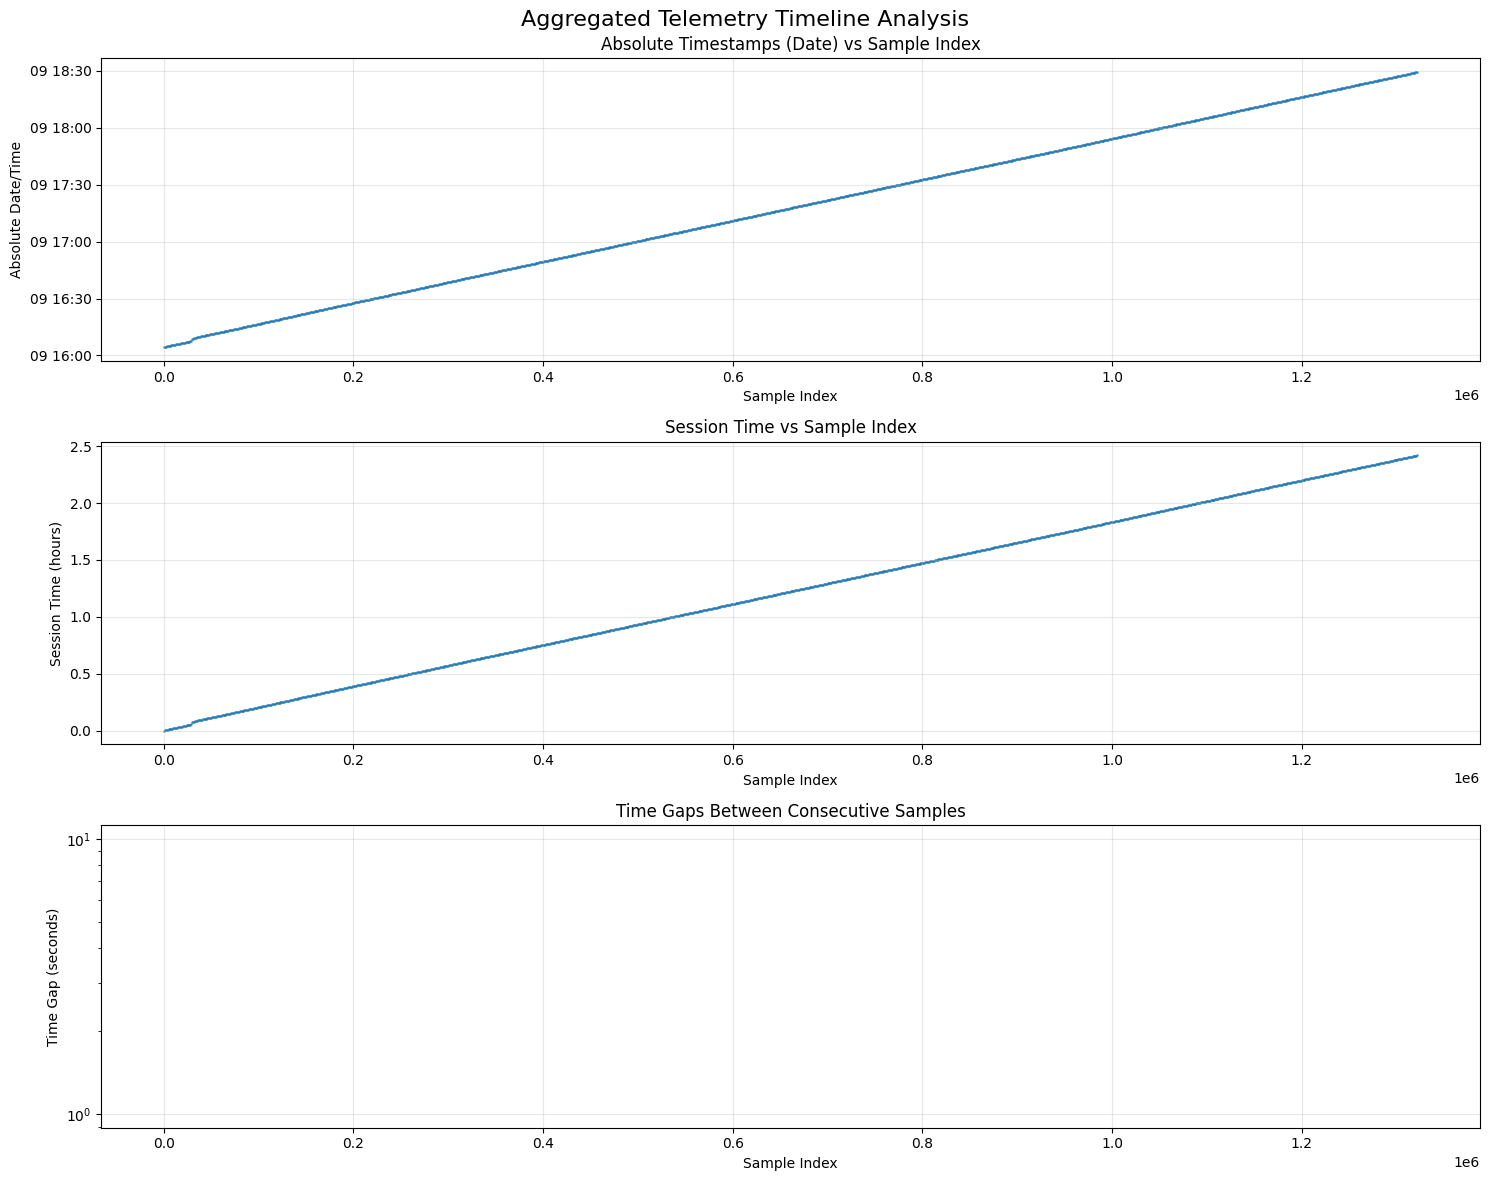


=== CONTAMINATION RISK ASSESSMENT ===
Single session detected - no cross-session contamination possible

=== WINDOW CONTAMINATION CHECK (window_size=100) ===
Found 0 session boundaries


In [9]:
# In your old pipeline, after this line:
# telemetry_data = aggregator.aggregate_telemetry_data(sessions_data, config.drivers)

# Add this:
plot_aggregated_telemetry_timeline(telemetry_data)
contamination_free = check_window_contamination_at_boundaries(telemetry_data, window_size=100)